
# 1. INTRODUCTION
<center>
<img src="https://i0.wp.com/post.medicalnewstoday.com/wp-content/uploads/sites/3/2020/09/Liver_failure_GettyImages862699664_header-1024x575.jpg?w=1155&h=1528" width=1300 height=1000 />
</center>

**PROBLEM STATEMENT: Cirrhosis Patient Survival Prediction**

<font size="3">Develop a machine learning model using 17 clinical features to predict the survival state of patients with liver cirrhosis. The survival states, categorized as 0 = D (death), 1 = C (censored), and 2 = CL (censored due to liver transplantation), will be inferred from data sourced from a Mayo Clinic study on primary biliary cirrhosis (PBC) of the liver conducted between 1974 and 1984.</font>



# 2. IMPORTS

In [1]:
import sklearn
import numpy as np
import os
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno
from prettytable import PrettyTable
%matplotlib inline
import seaborn as sns
sns.set(style='darkgrid', font_scale=1.4)
from tqdm import tqdm
from tqdm.notebook import tqdm as tqdm_notebook
tqdm_notebook.get_lock().locks = []
# !pip install sweetviz
# import sweetviz as sv
import concurrent.futures
from copy import deepcopy       
from functools import partial
from itertools import combinations
import random
from random import randint, uniform
import gc
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler,PowerTransformer, FunctionTransformer
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from itertools import combinations
from sklearn.impute import SimpleImputer
import xgboost as xg
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import mean_squared_error,mean_squared_log_error, roc_auc_score, accuracy_score, f1_score, precision_recall_curve, log_loss
from sklearn.cluster import KMeans
!pip install yellowbrick
from yellowbrick.cluster import KElbowVisualizer
!pip install gap-stat
from gap_statistic.optimalK import OptimalK
from scipy import stats
import statsmodels.api as sm
from scipy.stats import ttest_ind
from scipy.stats import boxcox
import math
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.base import BaseEstimator, TransformerMixin
!pip install optuna
import optuna
!pip install cmaes
import cmaes
import xgboost as xgb
!pip install catboost
!pip install lightgbm --install-option=--gpu --install-option="--boost-root=C:/local/boost_1_69_0" --install-option="--boost-librarydir=C:/local/boost_1_69_0/lib64-msvc-14.1"
import lightgbm as lgb
!pip install category_encoders
from category_encoders import OneHotEncoder, OrdinalEncoder, CountEncoder, CatBoostEncoder
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, GradientBoostingClassifier,ExtraTreesClassifier, AdaBoostClassifier
!pip install -U imbalanced-learn
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.naive_bayes import GaussianNB
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoost, CatBoostRegressor, CatBoostClassifier
from sklearn.svm import NuSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import KNNImputer
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from catboost import Pool
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")
pd.pandas.set_option('display.max_columns',None)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


  Installing build dependencies ... - \ | / - \ done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... - \ | / - \ | / - \ | / - \ | / - \ | / - done
  Preparing metadata (pyproject.toml) ... - done
  Created wheel for gap-stat: filename=gap_stat-2.0.3-py3-none-any.whl size=6133 sha256=49f87fad4308c1c6d2dfa37f708ed61c15d7389d5a07f132b50829a6cd92606d
  Stored in directory: /root/.cache/pip/wheels/e6/75/de/ee29b366258cdeccdacaff94d895b9d2ffc95a486f3b982441
Successfully built gap-stat
  Obtaining dependency information for cmaes from https://files.pythonhosted.org/packages/f7/46/7d9544d453346f6c0c405916c95fdb653491ea2e9976cabb810ba2fe8cd4/cmaes-0.10.0-py3-none-any.whl.metadata

Usage:   
  pip install [options] <requirement specifier> [package-index-options] ...
  pip install [options] -r <requirements file> [package-index-options] ...
  pip install [options] [-e] <vcs project url> ...
  pip install

/opt/conda/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(


/opt/conda/lib/python3.10/site-packages/sklearn/experimental/enable_hist_gradient_boosting.py:16: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


## 2.1 LOAD DATA

In [2]:
train=pd.read_csv('/kaggle/input/playground-series-s3e26/train.csv')
test=pd.read_csv('/kaggle/input/playground-series-s3e26/test.csv')
original=pd.read_csv("/kaggle/input/cirrhosis-patient-survival-prediction/cirrhosis.csv")

train.drop(columns=["id"],inplace=True)
test.drop(columns=["id"],inplace=True)
original.drop(columns=["ID"],inplace=True)

train_copy=train.copy()
test_copy=test.copy()
original_copy=original.copy()

# cols=[f for f in train.columns if train[f].isna().sum()==0 and original[f].isna().sum()>0]
# original=original.loc[original[cols].dropna().index.tolist()]
# print(original.shape)

original["original"]=1

train["original"]=0
test["original"]=0

train=pd.concat([train,original],axis=0)
train.reset_index(inplace=True,drop=True)

target='Status'

train.head()

,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status,original
0,999,D-penicillamine,21532,M,N,N,N,N,2.3,316.0,3.35,172.0,1601.0,179.80,63.0,394.0,9.7,3.0,D,0
1,2574,Placebo,19237,F,N,N,N,N,0.9,364.0,3.54,63.0,1440.0,134.85,88.0,361.0,11.0,3.0,C,0
2,3428,Placebo,13727,F,N,Y,Y,Y,3.3,299.0,3.55,131.0,1029.0,119.35,50.0,199.0,11.7,4.0,D,0
3,2576,Placebo,18460,F,N,N,N,N,0.6,256.0,3.50,58.0,1653.0,71.30,96.0,269.0,10.7,3.0,C,0
4,788,Placebo,16658,F,N,Y,N,N,1.1,346.0,3.65,63.0,1181.0,125.55,96.0,298.0,10.6,4.0,C,0


## 2.2 MISSING VALUE CHECKS

In [3]:
table = PrettyTable()

table.field_names = ['Feature', 'Data Type', 'Train Missing %', 'Test Missing %',"Original Missing%"]
for column in train_copy.columns:
    data_type = str(train_copy[column].dtype)
    non_null_count_train= np.round(100-train_copy[column].count()/train_copy.shape[0]*100,1)
    if column!=target:
        non_null_count_test = np.round(100-test_copy[column].count()/test_copy.shape[0]*100,1)
    else:
        non_null_count_test="NA"
    non_null_count_orig= np.round(100-original_copy[column].count()/original_copy.shape[0]*100,1)
    table.add_row([column, data_type, non_null_count_train,non_null_count_test,non_null_count_orig])
print(table)

+---------------+-----------+-----------------+----------------+-------------------+
|    Feature    | Data Type | Train Missing % | Test Missing % | Original Missing% |
+---------------+-----------+-----------------+----------------+-------------------+
|     N_Days    |   int64   |       0.0       |      0.0       |        0.0        |
|      Drug     |   object  |       0.0       |      0.0       |        25.4       |
|      Age      |   int64   |       0.0       |      0.0       |        0.0        |
|      Sex      |   object  |       0.0       |      0.0       |        0.0        |
|    Ascites    |   object  |       0.0       |      0.0       |        25.4       |
|  Hepatomegaly |   object  |       0.0       |      0.0       |        25.4       |
|    Spiders    |   object  |       0.0       |      0.0       |        25.4       |
|     Edema     |   object  |       0.0       |      0.0       |        0.0        |
|   Bilirubin   |  float64  |       0.0       |      0.0       | 

<font size="3"> There are no missing values in the competition dataset but the original source has a lot of them. </font>

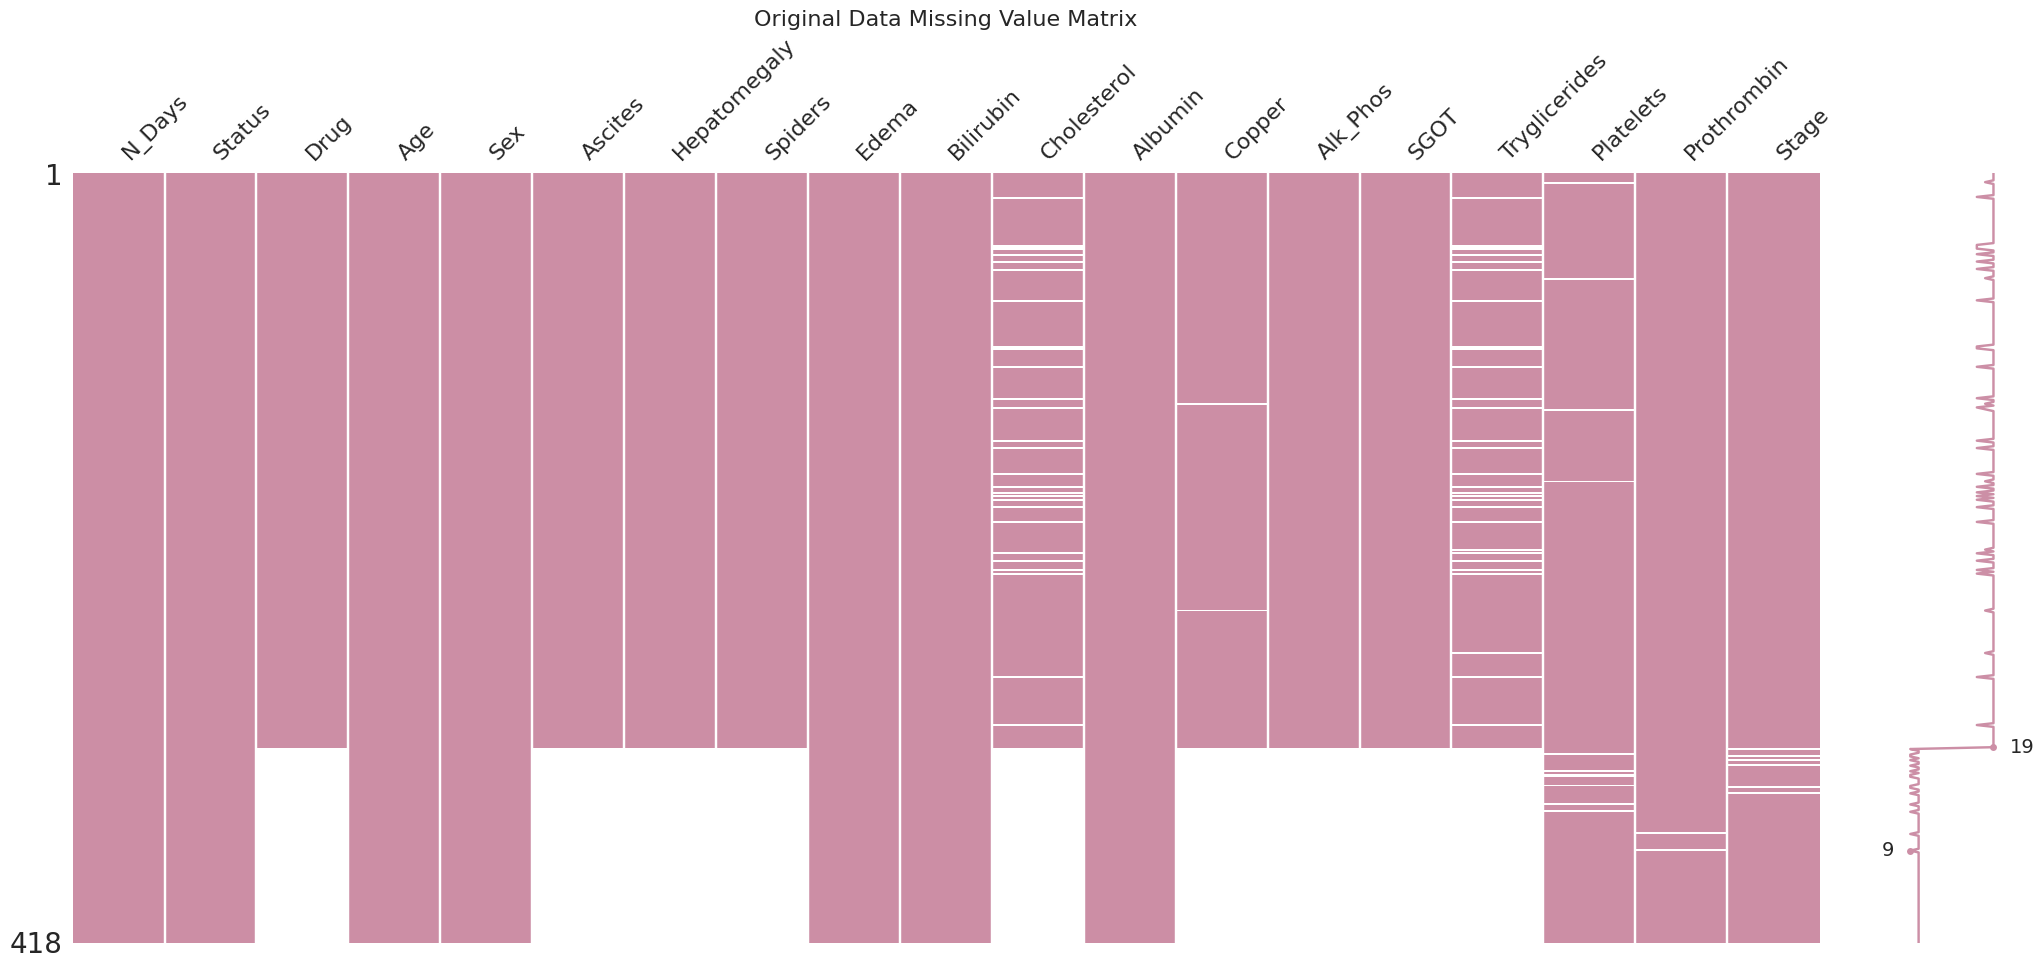

In [4]:
msno.matrix(original_copy, color=  (0.8, 0.56, 0.65))
plt.title("Original Data Missing Value Matrix", fontsize=16)
plt.show()

<font size="3">Interestingly, the same columns have missing values across 25% of the rows. I will try imputing them with some flag columns but I do think it's wise to drop them since the dataset has only 418 rows</font>

# 3. EXPLORATORY DATA ANALYSIS

## 3.1 TARGET DISTRIBUTIONS

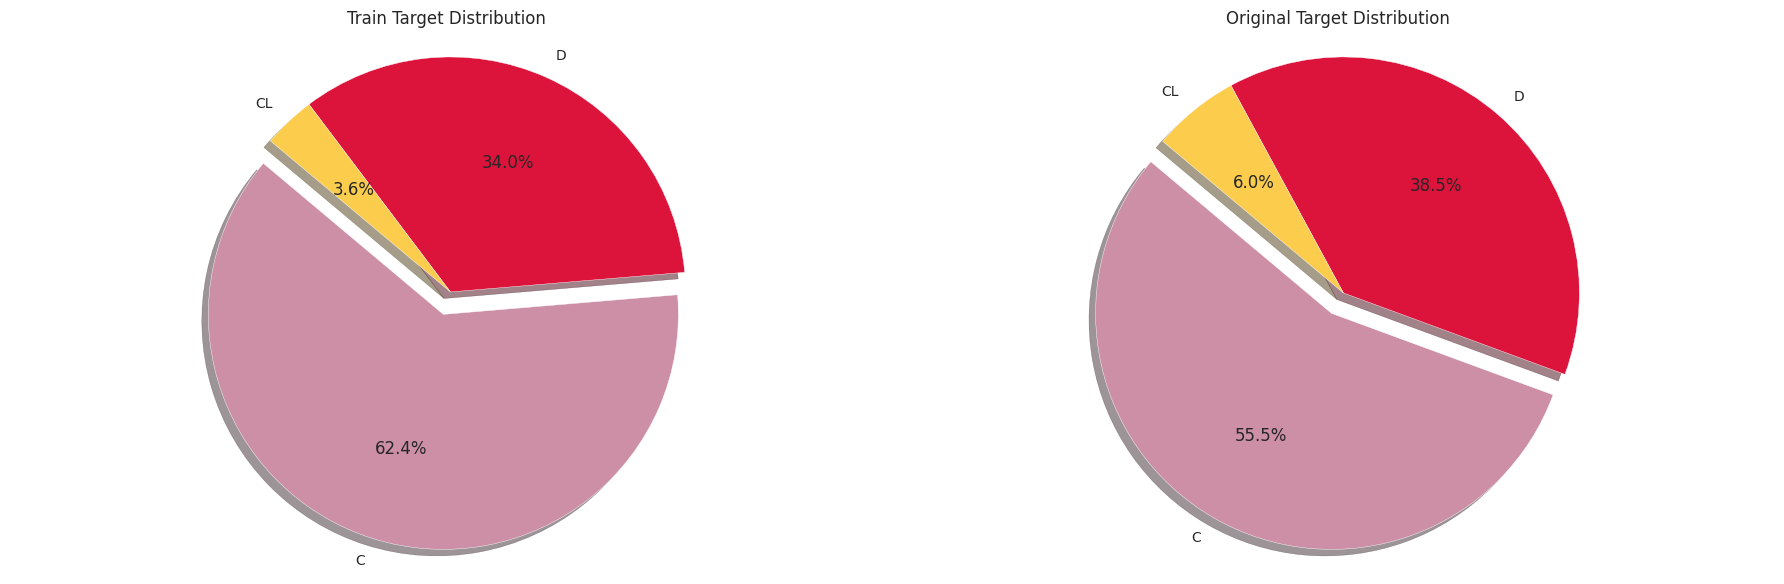

In [5]:
def plot_pie_chart(data, title, ax):
    data_counts = data[target].value_counts()
    labels = data_counts.index
    sizes = data_counts.values
    colors = [(0.8, 0.56, 0.65), 'crimson',  (0.99, 0.8, 0.3)]  
    explode = (0.1, 0, 0)  

    ax.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
    ax.axis('equal') 
    ax.set_title(title)

fig, axes = plt.subplots(1, 2, figsize=(18, 6))  # Create three subplots in a row

plot_pie_chart(train, "Train Target Distribution", axes[0])
plot_pie_chart(original, "Original Target Distribution", axes[1])

plt.tight_layout()
plt.show()


<font size="3">The orignal data has a bit more of Class "CL" than the synthetic one</font>

## 3.2 Numerical Feature Distributions

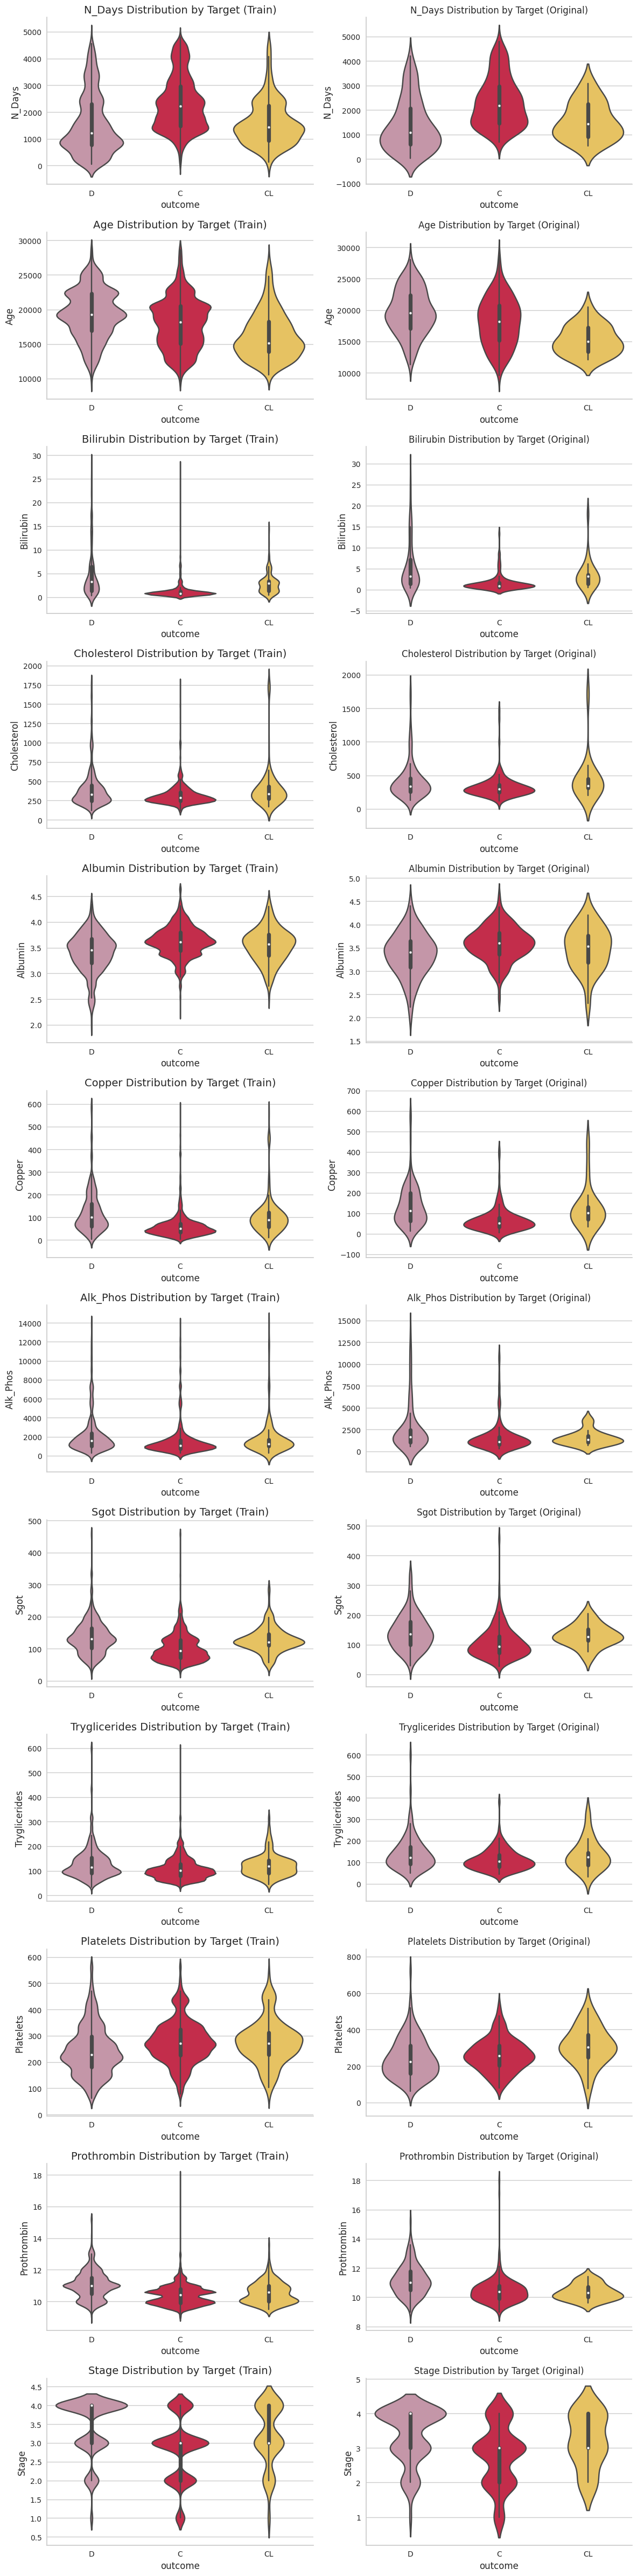

In [6]:
cont_cols = [f for f in train.columns if train[f].dtype != 'O' and train[f].nunique() > 2]
n_rows = len(cont_cols)
fig, axs = plt.subplots(n_rows, 2, figsize=(12, 4 * n_rows))
sns.set_palette([(0.8, 0.56, 0.65), 'crimson',  (0.99, 0.8, 0.3)])  

for i, col in enumerate(cont_cols):
    sns.violinplot(x=target, y=col, data=train_copy, ax=axs[i, 0])
    axs[i, 0].set_title(f'{col.title()} Distribution by Target (Train)', fontsize=14)
    axs[i, 0].set_xlabel('outcome', fontsize=12)
    axs[i, 0].set_ylabel(col.title(), fontsize=12)
    sns.despine()

    sns.violinplot(x=target, y=col, data=original, ax=axs[i, 1])
    axs[i, 1].set_title(f'{col.title()} Distribution by Target (Original)', fontsize=12)
    axs[i, 1].set_xlabel('outcome', fontsize=12)
    axs[i, 1].set_ylabel(col.title(), fontsize=12)
    sns.despine()

fig.tight_layout()

plt.show()


## **INFERENCES**
1. <font size="3">Bilirubin has distinguishable distribution</font>
2. <font size='3'>Even Copper, Albumin, Cholestrol are good features. Stage looks like a discrete feature, we have to confirm this</font>

## 3.3 Categorical Features Analysis

<font size="3">Few of the numerical columns that are discrete with less than 2.5% of unique values have been included in the categorical list</font>

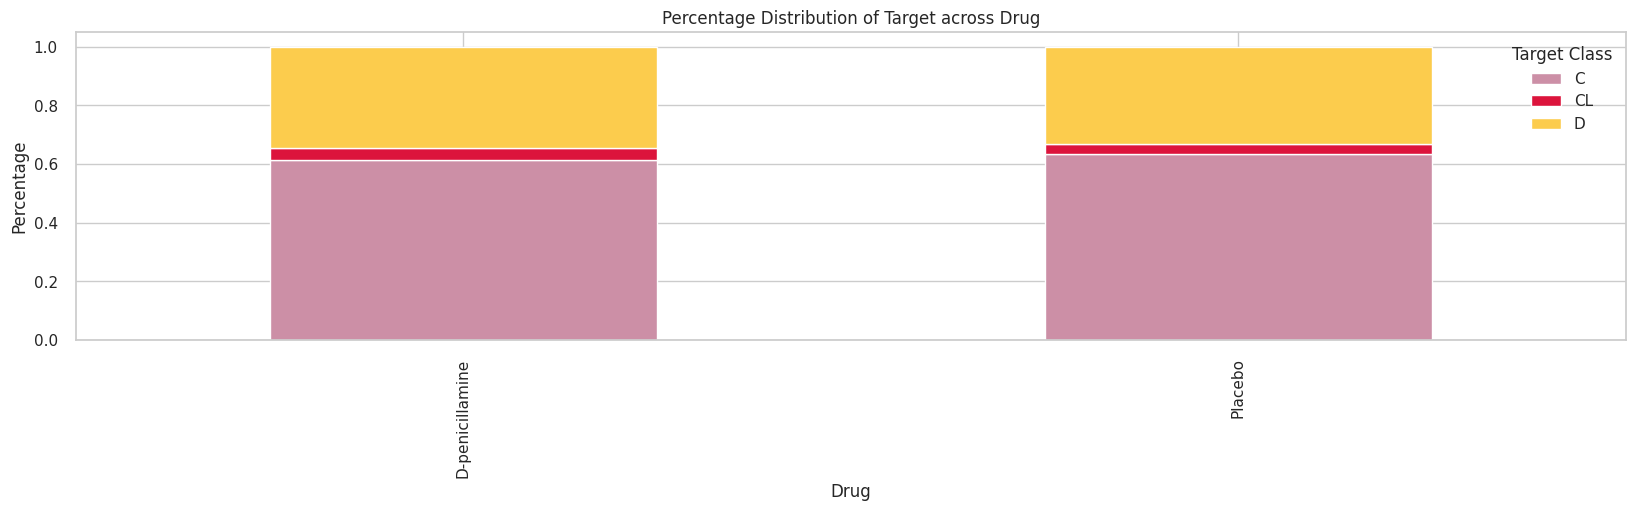

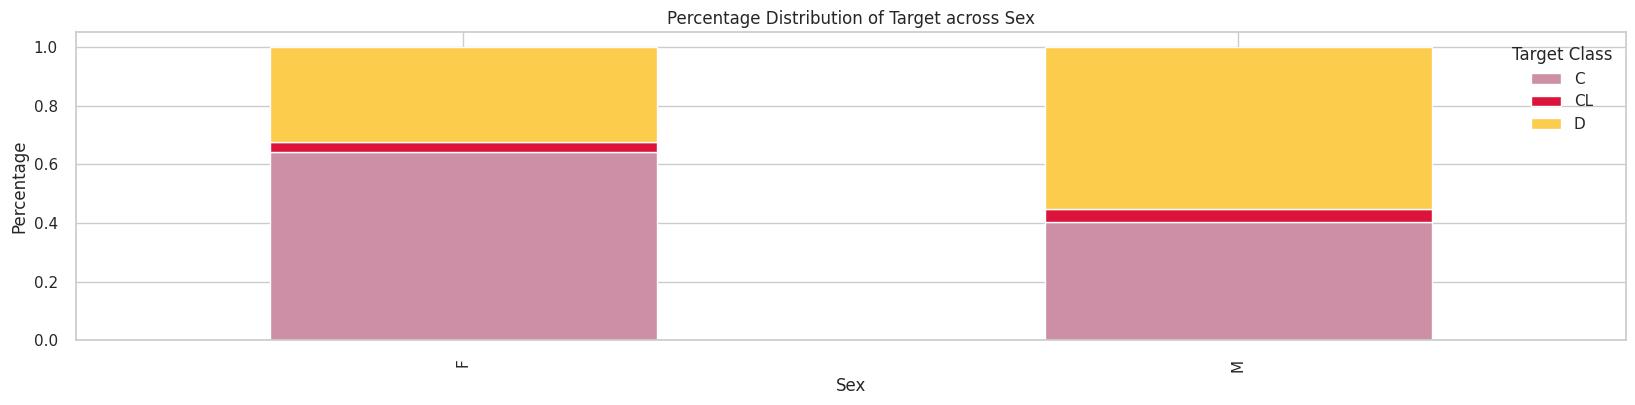

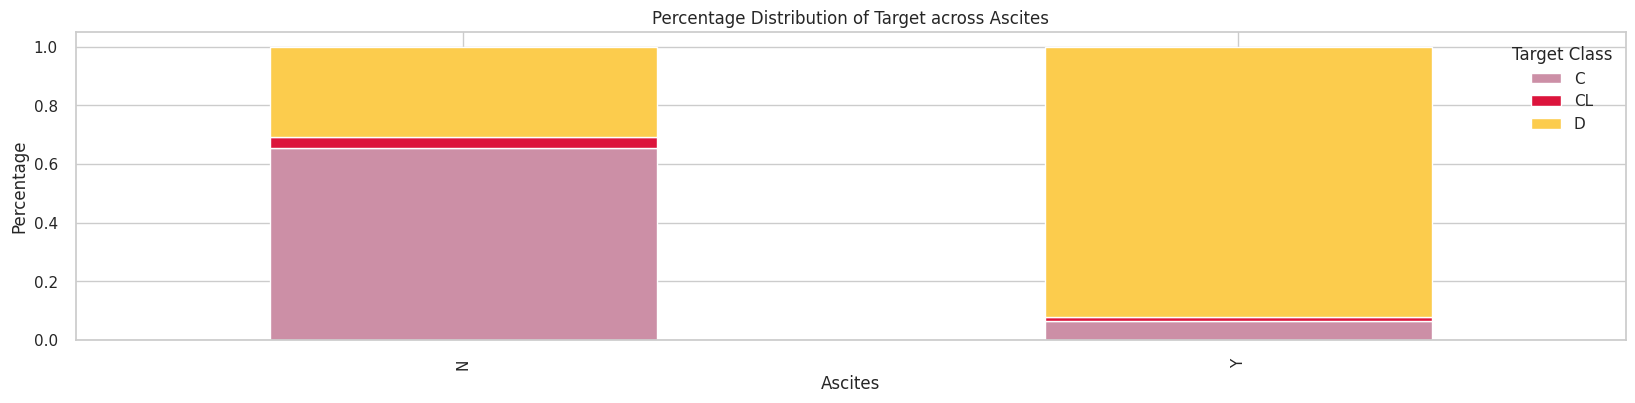

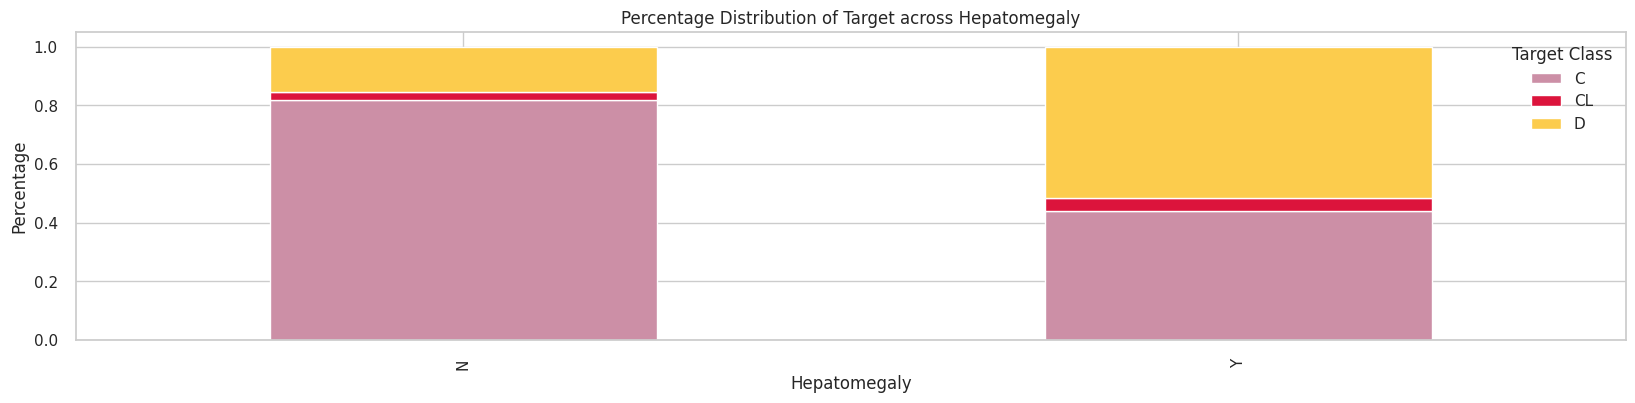

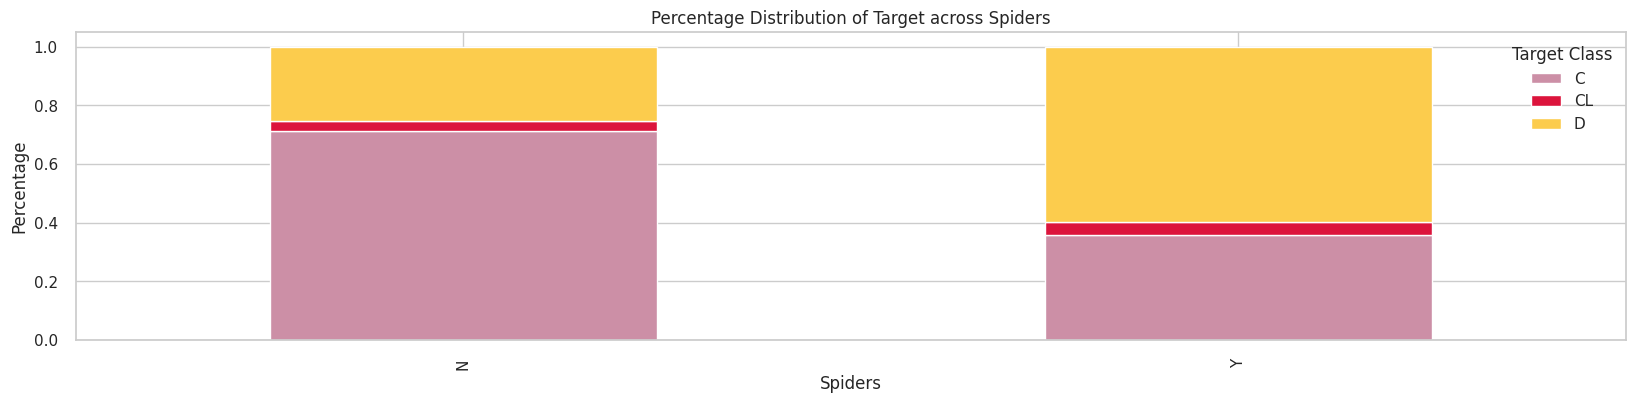

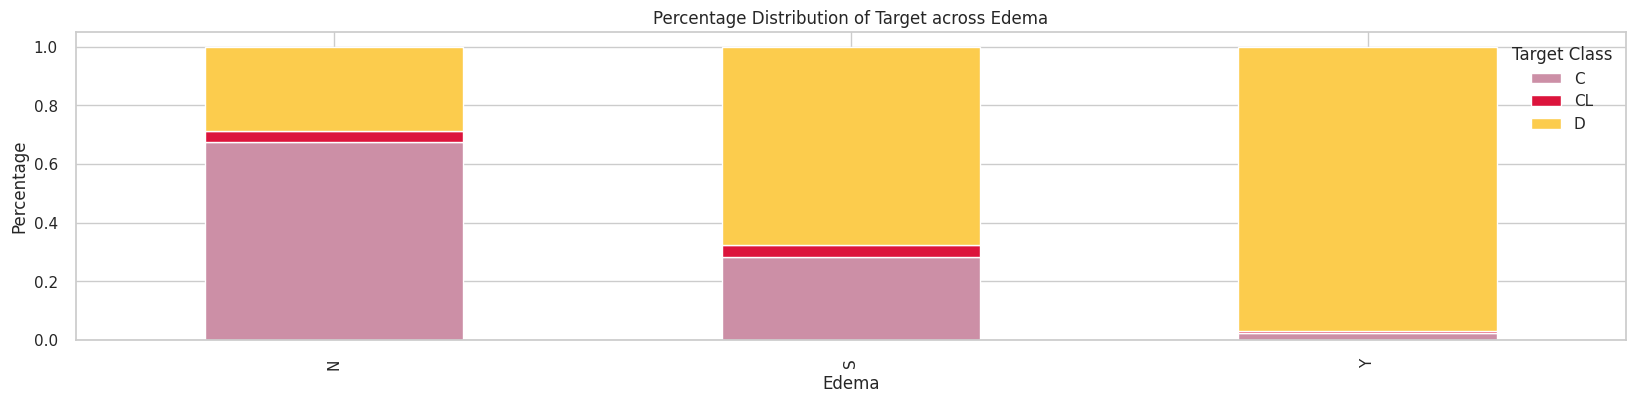

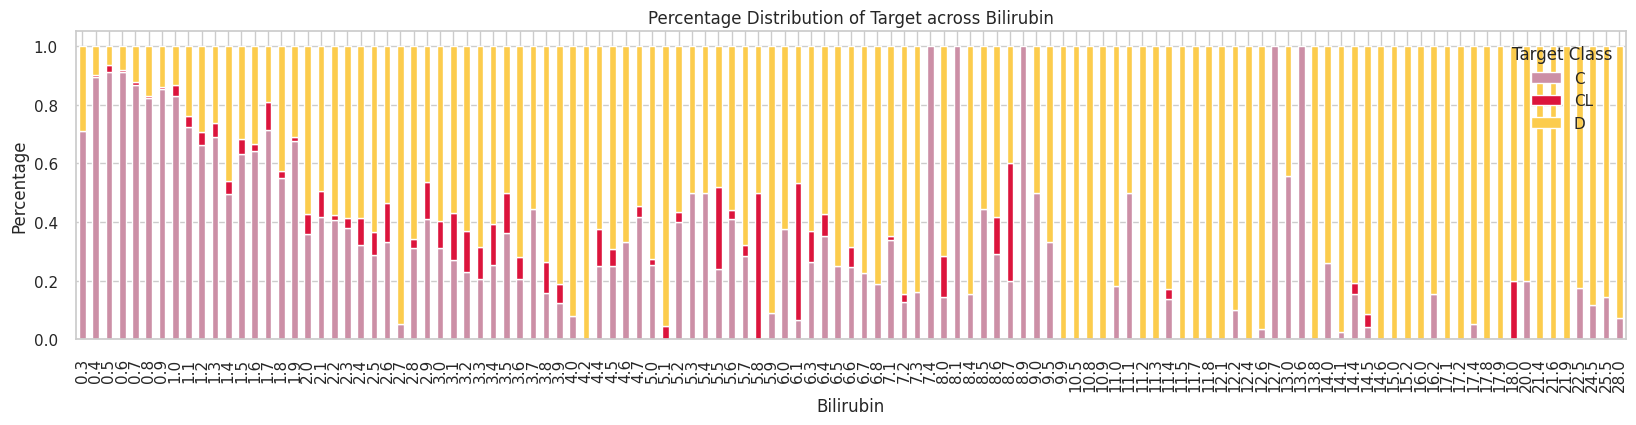

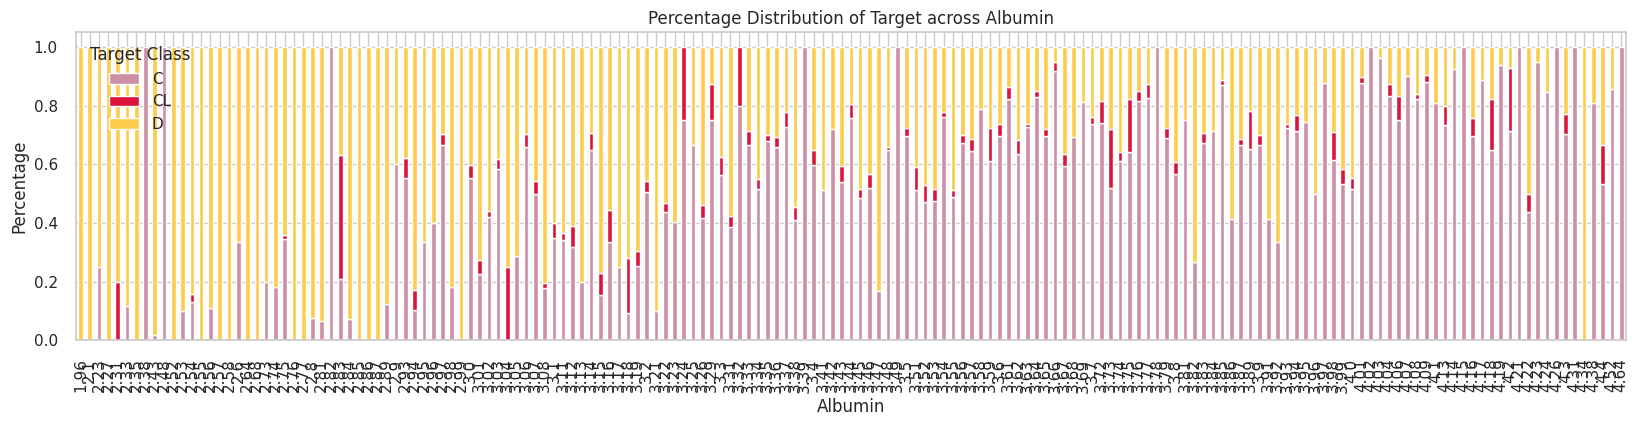

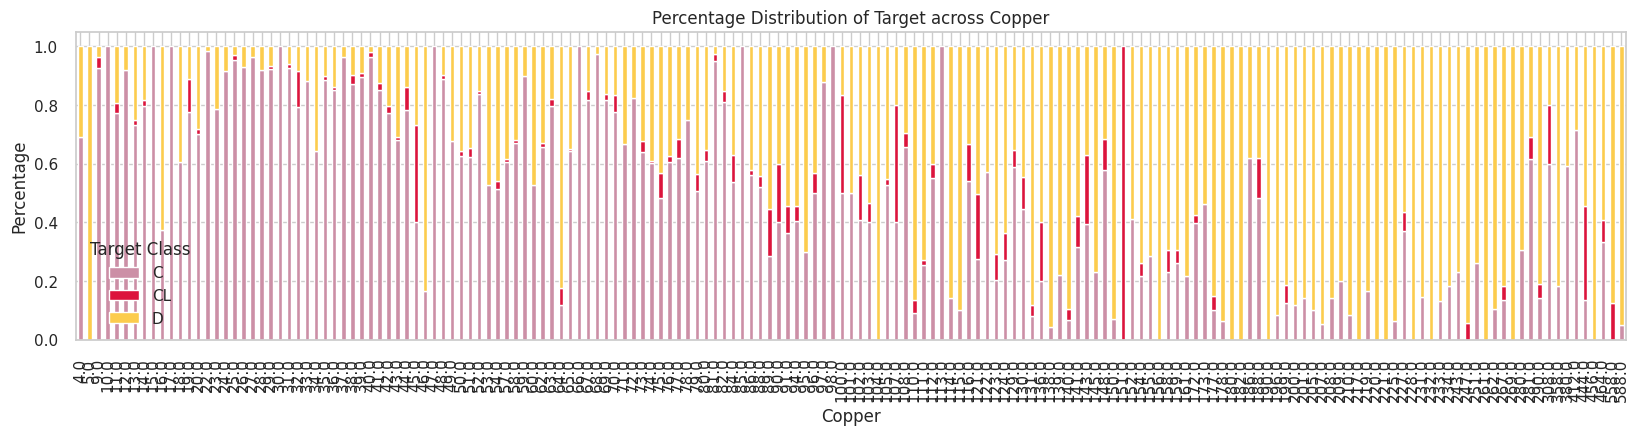

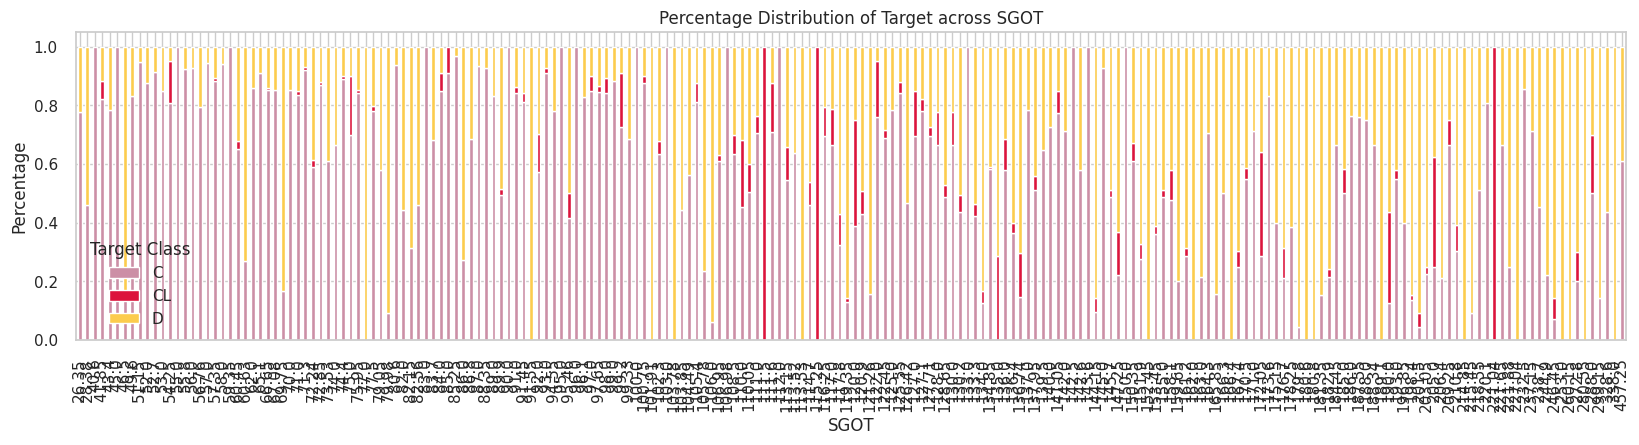

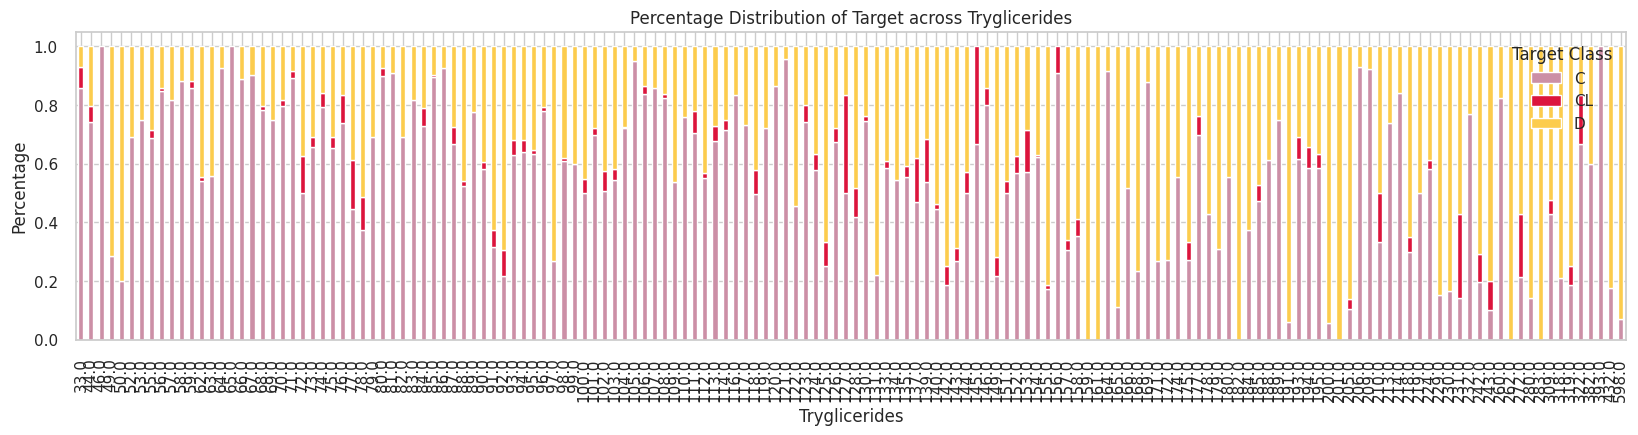

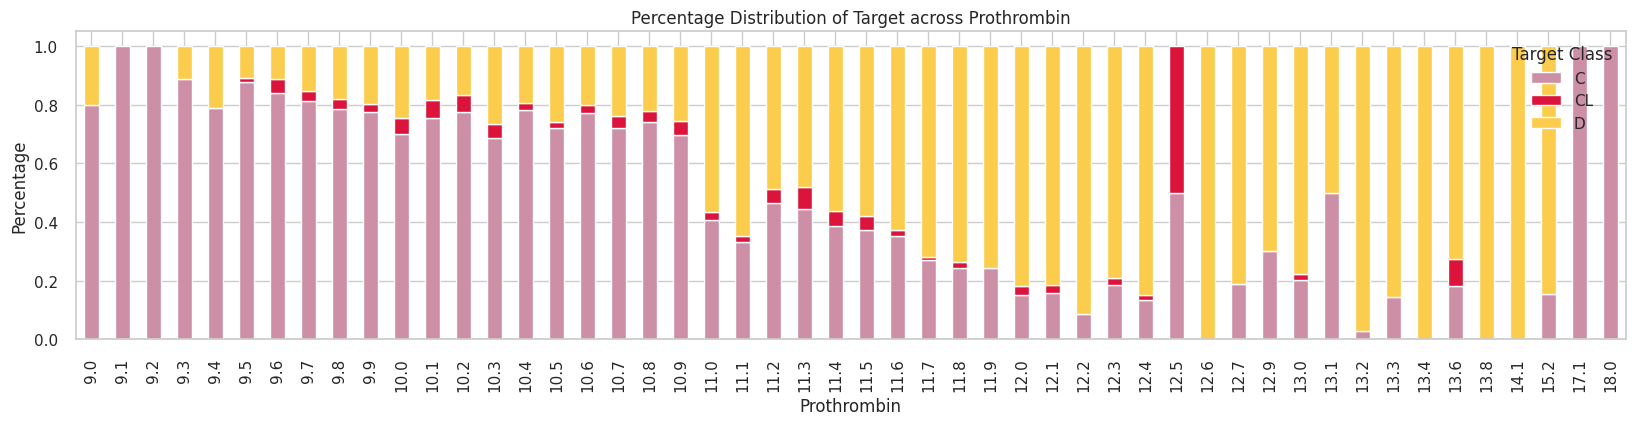

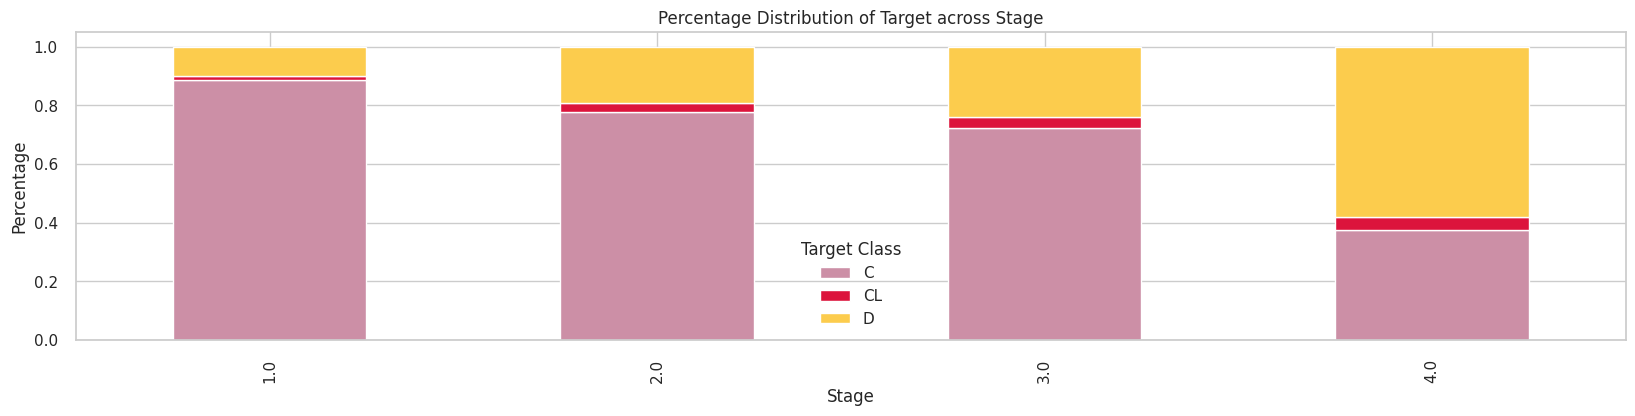

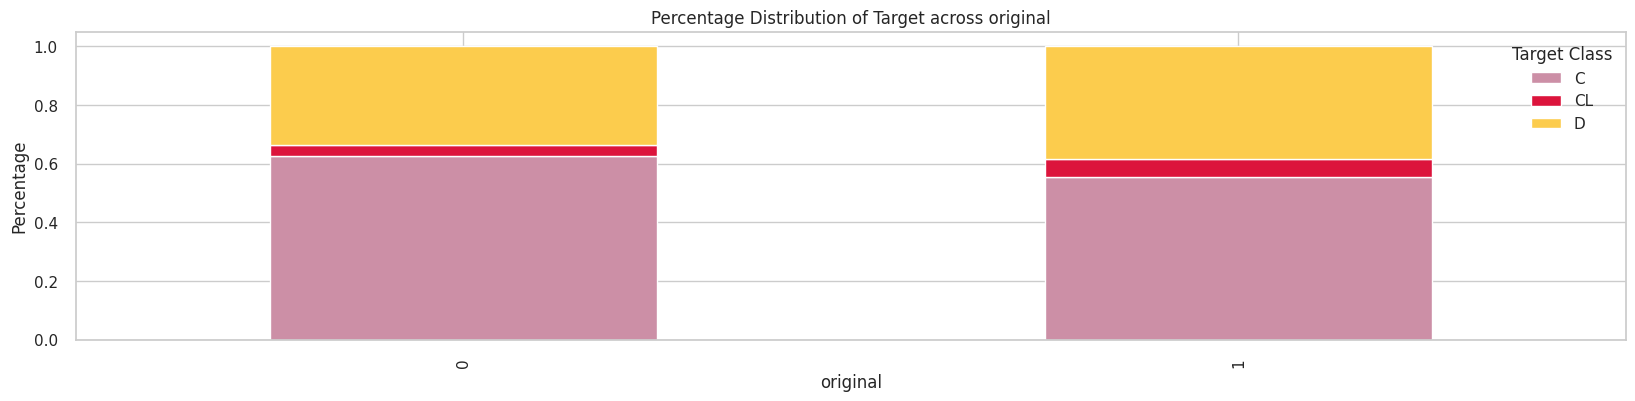

In [7]:
cat_cols = [f for f in train.columns if (train[f].dtype != 'O' and train[f].nunique() / train.shape[0] < 0.025) or (train[f].dtype == 'O' and f not in [target]) ]
custom_palette =(0.8, 0.56, 0.65), 'crimson',  (0.99, 0.8, 0.3)
for col in cat_cols:
    contingency_table = pd.crosstab(train[col], train[target], normalize='index')
    sns.set(style="whitegrid")
    contingency_table.plot(kind="bar", stacked=True, color=custom_palette,figsize=(20, 4))
    plt.title(f"Percentage Distribution of Target across {col}")
    plt.xlabel(col)
    plt.ylabel("Percentage")
    plt.legend(title="Target Class")
    plt.show()


# 4. IMPUTE MISSING VALUES

## 4.1 Impute Categorical features

In [8]:
missing_cat=[f for f in train.columns if train[f].dtype=="O" and train[f].isna().sum()>0]
train_missing_pct = train[missing_cat].isnull().mean() * 100
test_missing_pct = test[missing_cat].isnull().mean() * 100

missing_pct_df = pd.concat([train_missing_pct, test_missing_pct], axis=1, keys=['Train %', 'Test%'])
print(missing_pct_df)

               Train %  Test%
Drug          1.273579    0.0
Ascites       1.273579    0.0
Hepatomegaly  1.273579    0.0
Spiders       1.273579    0.0


In [9]:
cat_params={
            'depth': 6,
            'learning_rate': 0.1,
            'l2_leaf_reg': 0.7,
            'random_strength': 0.2,
            'max_bin': 200,
            'od_wait': 65,
            'one_hot_max_size': 70,
            'grow_policy': 'Depthwise',
            'bootstrap_type': 'Bayesian',
            'od_type': 'Iter',
            'eval_metric': 'MultiClass',
            'loss_function': 'MultiClass',
}
def store_missing_rows(df, features):
    missing_rows = {}
    
    for feature in features:
        missing_rows[feature] = df[df[feature].isnull()]
    
    return missing_rows

def fill_missing_categorical(train, test, target, features, max_iterations=10):
    df = pd.concat([train.drop(columns=target), test], axis="rows")
    df = df.reset_index(drop=True)

    # Step 1: Store the instances with missing values in each feature
    missing_rows = store_missing_rows(df, features)

    # Step 2: Initially fill all missing values with "Missing"
    for f in features:
        df[f] = df[f].fillna("Missing_" + f)

    for iteration in tqdm(range(max_iterations), desc="Iterations"):
        for feature in features:
            # Skip features with no missing values
            rows_miss = missing_rows[feature].index

            missing_temp = df.loc[rows_miss].copy()
            non_missing_temp = df.drop(index=rows_miss).copy()
            missing_temp = missing_temp.drop(columns=[feature])

            other_features = [x for x in df.columns if x != feature and df[x].dtype == "O"]

            X_train = non_missing_temp.drop(columns=[feature])
            y_train = non_missing_temp[[feature]]

            catboost_classifier = CatBoostClassifier(**cat_params)
            catboost_classifier.fit(X_train, y_train, cat_features=other_features, verbose=False)

            # Step 4: Predict missing values for the feature and update all N features
            y_pred = catboost_classifier.predict(missing_temp)
            
            # Convert y_pred to strings if necessary
            if y_pred.dtype != "O":
                y_pred = y_pred.astype(str)

            df.loc[rows_miss, feature] = y_pred

    train[features] = np.array(df.iloc[:train.shape[0]][features])
    test[features] = np.array(df.iloc[train.shape[0]:][features])

    return train, test

train, test = fill_missing_categorical(train, test, target, missing_cat, 5)

Iterations: 100%|██████████| 5/5 [04:02<00:00, 48.42s/it]


## 4.2 Impute Numerical Features

In [10]:
missing_num=[f for f in train.columns if train[f].dtype!="O" and train[f].isna().sum()>0]
train_missing_pct = train[missing_num].isnull().mean() * 100
test_missing_pct = test[missing_num].isnull().mean() * 100
missing_pct_df = pd.concat([train_missing_pct, test_missing_pct], axis=1, keys=['Train %', 'Test%'])
print(missing_pct_df)

                Train %  Test%
Cholesterol    1.609996    0.0
Copper         1.297609    0.0
Alk_Phos       1.273579    0.0
SGOT           1.273579    0.0
Tryglicerides  1.634026    0.0
Platelets      0.132164    0.0
Prothrombin    0.024030    0.0
Stage          0.072089    0.0


Iterations: 100%|██████████| 5/5 [02:15<00:00, 27.12s/it]


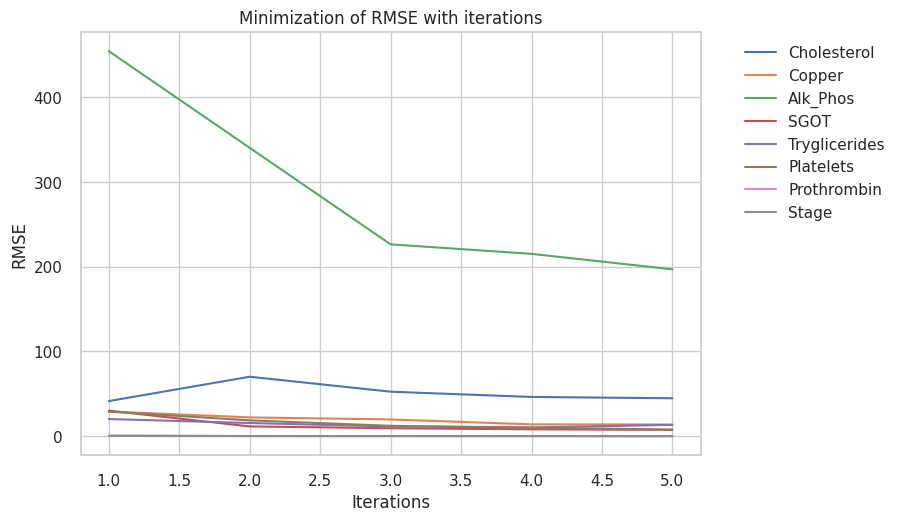

In [11]:
cb_params = {
            'iterations': 500,
            'depth': 6,
            'learning_rate': 0.02,
            'l2_leaf_reg': 0.5,
            'random_strength': 0.2,
            'max_bin': 150,
            'od_wait': 80,
            'one_hot_max_size': 70,
            'grow_policy': 'Depthwise',
            'bootstrap_type': 'Bayesian',
            'od_type': 'IncToDec',
            'eval_metric': 'RMSE',
            'loss_function': 'RMSE',
            'random_state': 42,
        }
lgb_params = {
            'n_estimators': 50,
            'max_depth': 8,
            'learning_rate': 0.02,
            'subsample': 0.20,
            'colsample_bytree': 0.56,
            'reg_alpha': 0.25,
            'reg_lambda': 5e-08,
            'objective': 'multiclass',
            'metric': 'multi_logloss',
            'boosting_type': 'gbdt',
            'random_state': 42,
        }
def rmse(y1,y2):
    return(np.sqrt(mean_squared_error(y1,y2)))

def fill_missing_numerical(train,test,target, features, max_iterations=10):
    train_temp=train.copy()
    if target in train_temp.columns:
        train_temp=train_temp.drop(columns=target)
        
    
    df=pd.concat([train_temp,test],axis="rows")
    df=df.reset_index(drop=True)
    
    # Step 1: Store the instances with missing values in each feature
    missing_rows = store_missing_rows(df, features)
    
    # Step 2: Initially fill all missing values with "Missing"
    for f in features:
        df[f]=df[f].fillna(df[f].mean())
    
    cat_features=[f for f in df.columns if not pd.api.types.is_numeric_dtype(df[f])]
    dictionary = {feature: [] for feature in features}
    
    for iteration in tqdm(range(max_iterations), desc="Iterations"):
        for feature in features:
            # Skip features with no missing values
            rows_miss = missing_rows[feature].index
            
            missing_temp = df.loc[rows_miss].copy()
            non_missing_temp = df.drop(index=rows_miss).copy()
            y_pred_prev=missing_temp[feature]
            missing_temp = missing_temp.drop(columns=[feature])
            
            
            # Step 3: Use the remaining features to predict missing values using Random Forests
            X_train = non_missing_temp.drop(columns=[feature])
            y_train = non_missing_temp[[feature]]
            
            model = CatBoostRegressor(**cb_params)
#             if iteration>3:
#                 model = lgb.LGBMRegressor()
            model.fit(X_train, y_train,cat_features=cat_features, verbose=False)
            
            # Step 4: Predict missing values for the feature and update all N features
            y_pred = model.predict(missing_temp)
            df.loc[rows_miss, feature] = y_pred
            error_minimize=rmse(y_pred,y_pred_prev)
            dictionary[feature].append(error_minimize)  # Append the error_minimize value

    for feature, values in dictionary.items():
        iterations = range(1, len(values) + 1)  # x-axis values (iterations)
        plt.plot(iterations, values, label=feature)  # plot the values
        plt.xlabel('Iterations')
        plt.ylabel('RMSE')
        plt.title('Minimization of RMSE with iterations')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()
    train[features] = np.array(df.iloc[:train.shape[0]][features])
    test[features] = np.array(df.iloc[train.shape[0]:][features])

    return train,test


train,test = fill_missing_numerical(train,test,target,missing_num,5)

# 5. FEATURE ENGINEERING

### Basic Functions

In [12]:
target_map={
'C':0,
'CL':1,
'D':2}
    

def encode(y,target_map):
    '''
    To convert the outputs to numbers
    '''
    y=np.array(y)
    encoded_y=[target_map[f] for f in y]
    return encoded_y
def decode(y,target_map):
    '''To convert the predictions back to classes
    '''
    y=np.array(y)
    reverse_dict={v: k for k, v in target_map.items()}
    decoded_y=[reverse_dict[f] for f in y]
    return decoded_y
def min_max_scaler(train, test, column):
    '''
    Min Max just based on train might have an issue if test has extreme values, hence changing the denominator uding overall min and max
    '''
    sc=MinMaxScaler()
    
    max_val=max(train[column].max(),test[column].max())
    min_val=min(train[column].min(),test[column].min())

    train[column]=(train[column]-min_val)/(max_val-min_val)
    test[column]=(test[column]-min_val)/(max_val-min_val)
    
    return train,test  

def OHE(train_df,test_df,cols,target):
    '''
    Function for one hot encoding, it first combined the data so that no category is missed and
    the category with least frequency can be dropped because of redunancy
    '''
    combined = pd.concat([train_df, test_df], axis=0)
    for col in cols:
        one_hot = pd.get_dummies(combined[col])
        counts = combined[col].value_counts()
        min_count_category = counts.idxmin()
        one_hot = one_hot.drop(min_count_category, axis=1)
        one_hot.columns=[str(f)+col for f in one_hot.columns]
        combined = pd.concat([combined, one_hot], axis="columns")
        combined = combined.loc[:, ~combined.columns.duplicated()]
    
    # split back to train and test dataframes
    train_ohe = combined[:len(train_df)]
    test_ohe = combined[len(train_df):]
    test_ohe.reset_index(inplace=True,drop=True)
    test_ohe.drop(columns=[target],inplace=True)
    return train_ohe, test_ohe

# 5.1 Numerical Transformations

<font size="3">We're going to see what transformation works better for each feature and select them, the idea is to compress the data. There could be situations where you will have to stretch the data. These are the methods applied:</font>

1. **Log Transformation**: <font size="3">This transformation involves taking the logarithm of each data point. It is useful when the data is highly skewed and the variance increases with the mean.</font>
                y = log(x)

2. **Square Root Transformation**: <font size="3">This transformation involves taking the square root of each data point. It is useful when the data is highly skewed and the variance increases with the mean.</font>
                y = sqrt(x)

3. **Box-Cox Transformation**: <font size="3">This transformation is a family of power transformations that includes the log and square root transformations as special cases. It is useful when the data is highly skewed and the variance increases with the mean.</font>
                y = [(x^lambda) - 1] / lambda if lambda != 0
                y = log(x) if lambda = 0

4. **Yeo-Johnson Transformation**: <font size="3">This transformation is similar to the Box-Cox transformation, but it can be applied to both positive and negative values. It is useful when the data is highly skewed and the variance increases with the mean.</font>
                y = [(|x|^lambda) - 1] / lambda if x >= 0, lambda != 0
                y = log(|x|) if x >= 0, lambda = 0
                y = -[(|x|^lambda) - 1] / lambda if x < 0, lambda != 2
                y = -log(|x|) if x < 0, lambda = 2

5. **Power Transformation**: <font size="3">This transformation involves raising each data point to a power. It is useful when the data is highly skewed and the variance increases with the mean. The power can be any value, and is often determined using statistical methods such as the Box-Cox or Yeo-Johnson transformations.</font>
                y = [(x^lambda) - 1] / lambda if method = "box-cox" and lambda != 0
                y = log(x) if method = "box-cox" and lambda = 0
                y = [(x + 1)^lambda - 1] / lambda if method = "yeo-johnson" and x >= 0, lambda != 0
                y = log(x + 1) if method = "yeo-johnson" and x >= 0, lambda = 0
                y = [-(|x| + 1)^lambda - 1] / lambda if method = "yeo-johnson" and x < 0, lambda != 2
                y = -log(|x| + 1) if method = "yeo-johnson" and x < 0, lambda = 2

In [13]:
cont_cols = [f for f in train.columns if pd.api.types.is_numeric_dtype(train[f]) and train[f].nunique() / train.shape[0] * 100 > 2.5]

sc=MinMaxScaler()

global unimportant_features
global overall_best_score
global overall_best_col
unimportant_features=[]
overall_best_score=100
overall_best_col='none'

for col in cont_cols:
     train, test=min_max_scaler(train, test, col)

def transformer(train, test,cont_cols, target):
    '''
    Algorithm applies multiples transformations on selected columns and finds the best transformation using a single variable model performance
    '''
    global unimportant_features
    global overall_best_score
    global overall_best_col
    train_copy = train.copy()
    test_copy = test.copy()
    table = PrettyTable()
    table.field_names = ['Feature', 'Original Log Loss', 'Transformation', 'Tranformed Log Loss']

    for col in cont_cols:
        
        for c in ["log_"+col, "sqrt_"+col, "bx_cx_"+col, "y_J_"+col, "log_sqrt"+col, "pow_"+col, "pow2_"+col]:
            if c in train_copy.columns:
                train_copy = train_copy.drop(columns=[c])
        
        # Log Transformation after MinMax Scaling (keeps data between 0 and 1)
        train_copy["log_"+col] = np.log1p(train_copy[col])
        test_copy["log_"+col] = np.log1p(test_copy[col])
        
        # Square Root Transformation
        train_copy["sqrt_"+col] = np.sqrt(train_copy[col])
        test_copy["sqrt_"+col] = np.sqrt(test_copy[col])
        
        # Box-Cox transformation
        combined_data = pd.concat([train_copy[[col]], test_copy[[col]]], axis=0)
        epsilon = 1e-5
        transformer = PowerTransformer(method='box-cox')
        scaled_data = transformer.fit_transform(combined_data + epsilon)

        train_copy["bx_cx_" + col] = scaled_data[:train_copy.shape[0]]
        test_copy["bx_cx_" + col] = scaled_data[train_copy.shape[0]:]
        # Yeo-Johnson transformation
        transformer = PowerTransformer(method='yeo-johnson')
        train_copy["y_J_"+col] = transformer.fit_transform(train_copy[[col]])
        test_copy["y_J_"+col] = transformer.transform(test_copy[[col]])
        
        # Power transformation, 0.25
        power_transform = lambda x: np.power(x + 1 - np.min(x), 0.25)
        transformer = FunctionTransformer(power_transform)
        train_copy["pow_"+col] = transformer.fit_transform(train_copy[[col]])
        test_copy["pow_"+col] = transformer.transform(test_copy[[col]])
        
        # Power transformation, 2
        power_transform = lambda x: np.power(x + 1 - np.min(x), 2)
        transformer = FunctionTransformer(power_transform)
        train_copy["pow2_"+col] = transformer.fit_transform(train_copy[[col]])
        test_copy["pow2_"+col] = transformer.transform(test_copy[[col]])
        
        # Log to power transformation
        train_copy["log_sqrt"+col] = np.log1p(train_copy["sqrt_"+col])
        test_copy["log_sqrt"+col] = np.log1p(test_copy["sqrt_"+col])
        
        temp_cols = [col, "log_"+col, "sqrt_"+col, "bx_cx_"+col, "y_J_"+col, "log_sqrt"+col, "pow_"+col, "pow2_"+col]
        
        train_copy[temp_cols] = train_copy[temp_cols].fillna(0)
        test_copy[temp_cols] = test_copy[temp_cols].fillna(0)
        
        pca = TruncatedSVD(n_components=1)
        x_pca_train = pca.fit_transform(train_copy[temp_cols])
        x_pca_test = pca.transform(test_copy[temp_cols])
        x_pca_train = pd.DataFrame(x_pca_train, columns=[col+"_pca_comb"])
        x_pca_test = pd.DataFrame(x_pca_test, columns=[col+"_pca_comb"])
        temp_cols.append(col+"_pca_comb")
        
        test_copy = test_copy.reset_index(drop=True)
        
        train_copy = pd.concat([train_copy, x_pca_train], axis='columns')
        test_copy = pd.concat([test_copy, x_pca_test], axis='columns')
        
        kf = KFold(n_splits=5, shuffle=True, random_state=42)
        
        ll_scores = []
        
        for f in temp_cols:
            X = train_copy[[f]].values
            y = train_copy[target].values
            
            log_loss_score = []
            for train_idx, val_idx in kf.split(X, y):
                X_train, y_train = X[train_idx], y[train_idx]
                x_val, y_val = X[val_idx], y[val_idx]
#                 model =   SVC(gamma="auto", probability=True, random_state=42)
                model =   CatBoostClassifier(**cat_params,verbose=False)
                model= lgb.LGBMClassifier(**lgb_params)

                model.fit(X_train, encode(y_train, target_map))
                y_pred = model.predict_proba(x_val)
#                 print(log_loss(encode(y_val, target_map),y_pred))
                log_loss_score.append(log_loss(encode(y_val, target_map),y_pred))
            ll_scores.append((f, np.mean(log_loss_score)))
            
            if overall_best_score > np.mean(log_loss_score):
                overall_best_score = np.mean(log_loss_score)
                overall_best_col = log_loss_score

            if f == col:
                orig_mae = np.mean(log_loss_score)
                
        best_col, best_loss = sorted(ll_scores, key=lambda x: x[1], reverse=False)[0]
        cols_to_drop = [f for f in temp_cols if f != best_col]
        final_selection = [f for f in temp_cols if f not in cols_to_drop]
        
        if cols_to_drop:
            unimportant_features = unimportant_features+cols_to_drop
        table.add_row([col,orig_mae,best_col ,best_loss])
    print(table)   
    print("overall best CV Log Loss score: ",overall_best_score)
    return train_copy, test_copy

train, test= transformer(train, test,cont_cols, target)


+---------------+--------------------+---------------------+---------------------+
|    Feature    | Original Log Loss  |    Transformation   | Tranformed Log Loss |
+---------------+--------------------+---------------------+---------------------+
|     N_Days    | 0.6390626843897296 |     bx_cx_N_Days    |  0.6381699148672785 |
|      Age      | 0.7063226387862759 |       pow2_Age      |  0.706308110514338  |
|  Cholesterol  | 0.6858814491522015 |   log_Cholesterol   |  0.6856932173840693 |
|     Copper    | 0.6459438532150215 |        Copper       |  0.6459438532150215 |
|    Alk_Phos   | 0.6929361646796274 |  Alk_Phos_pca_comb  |  0.6929004519719868 |
|      SGOT     | 0.6771357073341916 |         SGOT        |  0.6771357073341916 |
| Tryglicerides | 0.7148264934944918 | bx_cx_Tryglicerides |  0.7147793443501946 |
|   Platelets   | 0.6991412334203286 |   bx_cx_Platelets   |  0.6989633895463259 |
+---------------+--------------------+---------------------+---------------------+
over

# 5.2 Categorical Encoding

<font size="3">For each categorical/discrete variable, perform the following encoding techniques:</font>


* **Count/Frequency Encoding**: Count the number of occurrences of each category and replace the category with its count.
* **Count Labeling**: Assign a label to each category based on its count, with higher counts receiving higher labels.
* **Target-Guided Mean Encoding**: Rank the categories based on the mean of target column across each category
* **One-Hot Encoding**: Apply OHE if the unique  value is less than 15(avoid creating so many features)

Please note that a particular encoding technique is not selected only if it has superior technique and the correlation with that is high

In [14]:
cat_cols = [f for f in train.columns if (train[f].dtype != 'O' and train[f].nunique() / train.shape[0] < 0.025) or (train[f].dtype == 'O' and f not in [target]) ]


for col in cat_cols:
    if train[col].dtype=="O":
        train[col]=train[col].astype(str)+"_"+col
        test[col]=test[col].astype(str)+"_"+col

In [15]:

def cat_encoding(train, test, target):
    global overall_best_score
    global overall_best_col
    table = PrettyTable()
    table.field_names = ['Feature', 'Encoded Features', 'F1 Score']
    train_copy=train.copy()
    test_copy=test.copy()
    train_dum = train.copy()
    train_dum[target] = encode(train[target], target_map)
    for feature in cat_cols:
#         print(feature)
        cat_labels = train_dum.groupby([feature])[target].mean().sort_values().index
        cat_labels2 = {k: i for i, k in enumerate(cat_labels, 0)}
        train_copy[feature + "_target"] = train[feature].map(cat_labels2)
        test_copy[feature + "_target"] = test[feature].map(cat_labels2)

        dic = train[feature].value_counts().to_dict()
        train_copy[feature + "_count"] =train[feature].map(dic)
        test_copy[feature + "_count"] = test[feature].map(dic)

        dic2=train[feature].value_counts().to_dict()
        list1=np.arange(len(dic2.values()),0,-1) # Higher rank for high count
        # list1=np.arange(len(dic2.values())) # Higher rank for low count
        dic3=dict(zip(list(dic2.keys()),list1))
        train_copy[feature+"_count_label"]=train[feature].replace(dic3).astype(float)
        test_copy[feature+"_count_label"]=test[feature].replace(dic3).astype(float)

        temp_cols = [feature + "_target", feature + "_count", feature + "_count_label"]

        
        if train_copy[feature].dtype=='O':
            train_copy, test_copy = OHE(train_copy, test_copy, [feature], target)
            train_copy=train_copy.drop(columns=[feature])
            test_copy=test_copy.drop(columns=[feature])
        else:
            if train_copy[feature].nunique()<15:
                train_copy[feature+"_OHE"]=train_copy[feature].astype(str)+"_"+feature
                test_copy[feature+"_OHE"]=test_copy[feature].astype(str)+"_"+feature
                train_copy, test_copy = OHE(train_copy, test_copy, [feature], target)
                train_copy=train_copy.drop(columns=[feature+"_OHE"])
                test_copy=test_copy.drop(columns=[feature+"_OHE"])
                temp_cols.append(feature)
            

        kf = KFold(n_splits=5, shuffle=True, random_state=42)

        ll_scores = []

        for f in temp_cols:
            X = train_copy[[f]].values
            y = train_copy[target].values

            log_loss_score = []
            for train_idx, val_idx in kf.split(X, y):
                X_train, y_train = X[train_idx], y[train_idx]
                x_val, y_val = X[val_idx], y[val_idx]
                model =  lgb.LGBMClassifier(**lgb_params)

                model.fit(X_train, encode(y_train, target_map))
                y_pred = model.predict_proba(x_val)
                log_loss_score.append(log_loss(encode(y_val, target_map),y_pred))
                
            ll_scores.append((f, np.mean(log_loss_score)))
            if overall_best_score > np.mean(log_loss_score):
                overall_best_score = np.mean(log_loss_score)
                overall_best_col = f
        best_col, best_loss = sorted(ll_scores, key=lambda x: x[1], reverse=False)[0]

        corr = train_copy[temp_cols].corr(method='pearson')
        corr_with_best_col = corr[best_col]
        cols_to_drop = [f for f in temp_cols if corr_with_best_col[f] > 0.5 and f != best_col]
        final_selection = [f for f in temp_cols if f not in cols_to_drop]
        if cols_to_drop:
            train_copy = train_copy.drop(columns=cols_to_drop)
            test_copy = test_copy.drop(columns=cols_to_drop)

        table.add_row([feature, best_col, best_loss])

    print(table)
    print("overall best CV score: ", overall_best_score)
    return train_copy, test_copy

train, test= cat_encoding(train, test, target)


+--------------+---------------------+--------------------+
|   Feature    |   Encoded Features  |      F1 Score      |
+--------------+---------------------+--------------------+
|     Drug     |     Drug_target     | 0.7805145722433254 |
|     Sex      |      Sex_target     | 0.7732691367657132 |
|   Ascites    |    Ascites_target   | 0.7455962915483308 |
| Hepatomegaly | Hepatomegaly_target | 0.7072262213207916 |
|   Spiders    |    Spiders_target   | 0.7345846357358005 |
|    Edema     |     Edema_target    | 0.7291363675525362 |
|  Bilirubin   |   Bilirubin_target  | 0.6110322727343721 |
|   Albumin    |    Albumin_target   | 0.7068631089787232 |
| Prothrombin  |  Prothrombin_target | 0.6879292858040775 |
|    Stage     |     Stage_target    | 0.7131620555321015 |
|   original   |   original_target   | 0.7802888785720212 |
+--------------+---------------------+--------------------+
overall best CV score:  0.6110322727343721


# 5.3 Clustering

<font size="3"> All the unimportant features that are not the best transformation technique are selected and applied a K-Means Clustering technique</font>

In [16]:
table = PrettyTable()
table.field_names = ['Clustered Feature', 'Log Loss (CV-TRAIN)']
for col in cont_cols:
    sub_set=[f for f in unimportant_features if col in f]
    temp_train=train[sub_set]
    temp_test=test[sub_set]
    sc=StandardScaler()
    temp_train=sc.fit_transform(temp_train)
    temp_test=sc.transform(temp_test)
    model = KMeans()

    # print(ideal_clusters)
    kmeans = KMeans(n_clusters=25)
    kmeans.fit(np.array(temp_train))
    labels_train = kmeans.labels_

    train[col+"_unimp_cluster_WOE"] = labels_train
    test[col+"_unimp_cluster_WOE"] = kmeans.predict(np.array(temp_test))

    
    kf=KFold(n_splits=5, shuffle=True, random_state=42)
    
    X=train[[col+"_unimp_cluster_WOE"]].values
    y=train[target].values

    log_loss_score=[]
    for train_idx, val_idx in kf.split(X,y):
        X_train,y_train=X[train_idx],y[train_idx]
        x_val,y_val=X[val_idx],y[val_idx]
        model =  lgb.LGBMClassifier(**lgb_params)

        model.fit(X_train, encode(y_train, target_map))
        y_pred = model.predict_proba(x_val)
        log_loss_score.append(log_loss(encode(y_val, target_map),y_pred))

        
    table.add_row([col+"_unimp_cluster_WOE",np.mean(log_loss_score)])
    if overall_best_score>np.mean(log_loss_score):
        overall_best_score=np.mean(log_loss_score)
        overall_best_col=col+"_unimp_cluster_WOE"

print(table)
print("overall best CV score: ", overall_best_score)


+---------------------------------+---------------------+
|        Clustered Feature        | Log Loss (CV-TRAIN) |
+---------------------------------+---------------------+
|     N_Days_unimp_cluster_WOE    |  0.6630454580033176 |
|      Age_unimp_cluster_WOE      |  0.7353050192582022 |
|  Cholesterol_unimp_cluster_WOE  |  0.7391524664029667 |
|     Copper_unimp_cluster_WOE    |  0.6677809327759531 |
|    Alk_Phos_unimp_cluster_WOE   |  0.7347459411780218 |
|      SGOT_unimp_cluster_WOE     |  0.7171866998986575 |
| Tryglicerides_unimp_cluster_WOE |  0.7474793626510362 |
|   Platelets_unimp_cluster_WOE   |  0.7479014987204351 |
+---------------------------------+---------------------+
overall best CV score:  0.6110322727343721


Iterations: 100%|██████████| 3/3 [04:21<00:00, 87.09s/it]


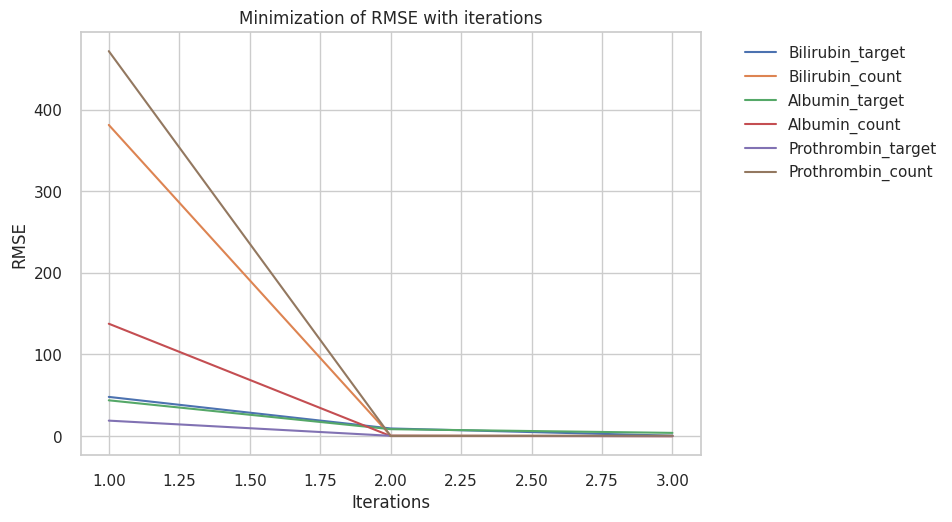

In [17]:
missing_num = [f for f in test.columns if (test[f].isna().sum() > 0).any()]
train,test = fill_missing_numerical(train,test,target,missing_num,3)

# 5.4 Arithmetic New Features

<font size="3">Until now, I have saved the best overall column and the best overall score, a few feature can be created based on the below criteria:</font>
* New features are based on the existing features by computing the arithmetic combinations
* The best arithmetic function is selected based on the individual performnace
* If the best arithmetic feature has better log loss score than the overall best score or the correlation of this feature with the existing features is less than 0.9, then a new feature is added to the dataset. 

In [18]:
def better_features(train, test, target, cols, best_score):
    new_cols = []
    skf = KFold(n_splits=5, shuffle=True, random_state=42)  # Stratified k-fold object
    best_list=[]
    for i in tqdm(range(len(cols)), desc='Generating Columns'):
        col1 = cols[i]
        temp_df = pd.DataFrame()  # Temporary dataframe to store the generated columns
        temp_df_test = pd.DataFrame()  # Temporary dataframe for test data

        for j in range(i+1, len(cols)):
            col2 = cols[j]
            # Multiply
            temp_df[col1 + '*' + col2] = train[col1] * train[col2]
            temp_df_test[col1 + '*' + col2] = test[col1] * test[col2]

            # Divide (col1 / col2)
            temp_df[col1 + '/' + col2] = train[col1] / (train[col2] + 1e-5)
            temp_df_test[col1 + '/' + col2] = test[col1] / (test[col2] + 1e-5)

            # Divide (col2 / col1)
            temp_df[col2 + '/' + col1] = train[col2] / (train[col1] + 1e-5)
            temp_df_test[col2 + '/' + col1] = test[col2] / (test[col1] + 1e-5)

            # Subtract
            temp_df[col1 + '-' + col2] = train[col1] - train[col2]
            temp_df_test[col1 + '-' + col2] = test[col1] - test[col2]

            # Add
            temp_df[col1 + '+' + col2] = train[col1] + train[col2]
            temp_df_test[col1 + '+' + col2] = test[col1] + test[col2]

        SCORES = []
        for column in temp_df.columns:
            scores = []
            for train_index, val_index in skf.split(train, train[target]):
                X_train, X_val = temp_df[column].iloc[train_index].values.reshape(-1, 1), temp_df[column].iloc[val_index].values.reshape(-1, 1)
                y_train, y_val = train[target].iloc[train_index], train[target].iloc[val_index]
                model = lgb.LGBMClassifier(**lgb_params)
                model.fit(X_train, encode(y_train, target_map))
                y_pred = model.predict_proba(X_val)
                scores.append(log_loss(encode(y_val, target_map),y_pred))
            mean_score = np.mean(scores)
            SCORES.append((column, mean_score))

        if SCORES:
            best_col, best_loss = sorted(SCORES, key=lambda x: x[1],reverse=False)[0]
            corr_with_other_cols = train.drop([target] + new_cols, axis=1).corrwith(temp_df[best_col])
            if (corr_with_other_cols.abs().max() < 0.9 or best_loss < best_score) and corr_with_other_cols.abs().max() !=1 :
                train[best_col] = temp_df[best_col]
                test[best_col] = temp_df_test[best_col]
                new_cols.append(best_col)
                print(f"Added column '{best_col}' with Log Loss Score: {best_loss:.4f} & Correlation {corr_with_other_cols.abs().max():.4f}")

    return train, test, new_cols

In [19]:
# selected_features=[f for f in test.columns if f not in unimportant_features and test[f].nunique()>2]
# train, test,new_cols=better_features(train, test, target, selected_features, overall_best_score)

<font size="3">We don't have to run the above algorithm every time, we can just store the combinations and compute the required columns. Unimportant columns and binary columns are not considered while assessing the combinations</font>

In [20]:
new_cols=['Bilirubin*Prothrombin_target',
 'Albumin/Bilirubin_target',
 'Copper+Bilirubin_target',
 'SGOT+Bilirubin_target',
 'Prothrombin*Bilirubin_target',
 'bx_cx_N_Days*Bilirubin_target',
 'pow2_Age*Bilirubin_target',
 'log_Cholesterol+Bilirubin_target',
 'Alk_Phos_pca_comb+Bilirubin_target',
 'bx_cx_Tryglicerides-Bilirubin_target',
 'bx_cx_Platelets-Bilirubin_target',
 'Bilirubin_target/Edema_target',
 'Edema_count-Bilirubin_target',
 'Bilirubin_target/Edema_count_label',
 'Bilirubin_target*Prothrombin_target',
 'Prothrombin_target/Bilirubin_count',
 'Bilirubin_count_label/Stage_target',
 'Albumin_target*Prothrombin_target',
 'Stage_target/Albumin_count',
 'Prothrombin_target/Albumin_count_label',
 'Stage_target/Prothrombin_count',
 'Prothrombin_count_label/Stage_target',
 'Stage_target/Copper_unimp_cluster_WOE',
 'N_Days_unimp_cluster_WOE/Copper_unimp_cluster_WOE',
 'Copper_unimp_cluster_WOE/Age_unimp_cluster_WOE',
 'Cholesterol_unimp_cluster_WOE/Copper_unimp_cluster_WOE',
 'SGOT_unimp_cluster_WOE/Copper_unimp_cluster_WOE',
 'Alk_Phos_unimp_cluster_WOE/SGOT_unimp_cluster_WOE',
 'SGOT_unimp_cluster_WOE/Tryglicerides_unimp_cluster_WOE',
 'Platelets_unimp_cluster_WOE/Tryglicerides_unimp_cluster_WOE']

In [21]:
def apply_arithmetic_operations(train_df, test_df, expressions_list):
    for expression in expressions_list:
        if expression not in train_df.columns:
            # Split the expression based on operators (+, -, *, /)
            parts = expression.split('+') if '+' in expression else \
                    expression.split('-') if '-' in expression else \
                    expression.split('*') if '*' in expression else \
                    expression.split('/')

            # Get the DataFrame column names involved in the operation
            cols = [col for col in parts]

            # Perform the corresponding arithmetic operation based on the operator in the expression
            if cols[0] in train_df.columns and cols[1] in train_df.columns:
                if '+' in expression:
                    train_df[expression] = train_df[cols[0]] + train_df[cols[1]]
                    test_df[expression] = test_df[cols[0]] + test_df[cols[1]]
                elif '-' in expression:
                    train_df[expression] = train_df[cols[0]] - train_df[cols[1]]
                    test_df[expression] = test_df[cols[0]] - test_df[cols[1]]
                elif '*' in expression:
                    train_df[expression] = train_df[cols[0]] * train_df[cols[1]]
                    test_df[expression] = test_df[cols[0]] * test_df[cols[1]]
                elif '/' in expression:
                    train_df[expression] = train_df[cols[0]] / (train_df[cols[1]]+1e-5)
                    test_df[expression] = test_df[cols[0]] /( test_df[cols[1]]+1e-5)
    
    return train_df, test_df

train, test = apply_arithmetic_operations(train, test, new_cols)

# 5.5 Feature Elimination

**Steps to Eliminate Correlated Fruit Features:**

* Group features based on their parent feature. For example, all features derived from pulse come under one set
* Apply PCA on the set, Cluster-Target Encoding on the set
* See the performance of each feature on a cross-validated single feature-target model
* Select the feature with highest CV-MAE

In [22]:
first_drop=[ f for f in unimportant_features if f in train.columns]
train=train.drop(columns=first_drop)
test=test.drop(columns=first_drop)

In [23]:
final_drop_list=[]


table = PrettyTable()
table.field_names = ['Original', 'Final Transformation', 'Log Loss CV']
threshold=0.95
# It is possible that multiple parent features share same child features, so store selected features to avoid selecting the same feature again
best_cols=[]

for col in cont_cols:
    sub_set=[f for f in train.columns if (str(col) in str(f)) and (train[f].nunique()>2)]
#     print(sub_set)
    if len(sub_set)>2:
        correlated_features = []

        for i, feature in enumerate(sub_set):
            # Check correlation with all remaining features
            for j in range(i+1, len(sub_set)):
                correlation = np.abs(train[feature].corr(train[sub_set[j]]))
                # If correlation is greater than threshold, add to list of highly correlated features
                if correlation > threshold:
                    correlated_features.append(sub_set[j])

        # Remove duplicate features from the list
        correlated_features = list(set(correlated_features))
#         print(correlated_features)
        if len(correlated_features)>=2:

            temp_train=train[correlated_features]
            temp_test=test[correlated_features]
            #Scale before applying PCA
            sc=StandardScaler()
            temp_train=sc.fit_transform(temp_train)
            temp_test=sc.transform(temp_test)

            # Initiate PCA
            pca=TruncatedSVD(n_components=1)
            x_pca_train=pca.fit_transform(temp_train)
            x_pca_test=pca.transform(temp_test)
            x_pca_train=pd.DataFrame(x_pca_train, columns=[col+"_pca_comb_final"])
            x_pca_test=pd.DataFrame(x_pca_test, columns=[col+"_pca_comb_final"])
            train=pd.concat([train,x_pca_train],axis='columns')
            test=pd.concat([test,x_pca_test],axis='columns')

            # Clustering
            model = KMeans()
            kmeans = KMeans(n_clusters=10)
            kmeans.fit(np.array(temp_train))
            labels_train = kmeans.labels_

            train[col+'_final_cluster'] = labels_train
            test[col+'_final_cluster'] = kmeans.predict(np.array(temp_test))


            correlated_features=correlated_features+[col+"_pca_comb_final",col+"_final_cluster"]

            # See which transformation along with the original is giving you the best univariate fit with target
            kf=KFold(n_splits=5, shuffle=True, random_state=42)

            scores=[]

            for f in correlated_features:
                X=train[[f]].values
                y=train[target].values

                log_loss_score=[]
                for train_idx, val_idx in kf.split(X,y):
                    X_train,y_train=X[train_idx],y[train_idx]
                    X_val,y_val=X[val_idx],y[val_idx]
                    model = lgb.LGBMClassifier(**lgb_params)
                    model.fit(X_train, encode(y_train, target_map))
                    y_pred = model.predict_proba(x_val)
                    log_loss_score.append(log_loss(encode(y_val, target_map),y_pred))
                if f not in best_cols:
                    scores.append((f,np.mean(log_loss_score)))
            best_col, best_loss=sorted(scores, key=lambda x:x[1], reverse=False)[0]
            best_cols.append(best_col)

            cols_to_drop = [f for f in correlated_features if  f not in best_cols]
            if cols_to_drop:
                final_drop_list=final_drop_list+cols_to_drop
            table.add_row([col,best_col ,best_loss])

print(table)      

+----------+----------------------+-------------+
| Original | Final Transformation | Log Loss CV |
+----------+----------------------+-------------+
+----------+----------------------+-------------+


In [24]:
final_drop_list=[*set(final_drop_list)]
train=train.drop(columns=final_drop_list)
test=test.drop(columns=final_drop_list)

# 6. Feature Selection

In [25]:
final_features=[f for f in train.columns if f not in [target]]
final_features=[*set(final_features)]

sc=StandardScaler()

train_scaled=train.copy()
test_scaled=test.copy()
train_scaled[final_features]=sc.fit_transform(train[final_features])
test_scaled[final_features]=sc.transform(test[final_features])

In [26]:
def post_processor(train, test):
    cols=train.drop(columns=[target]).columns
    train_cop=train.copy()
    test_cop=test.copy()
    drop_cols=[]
    for i, feature in enumerate(cols):
        for j in range(i+1, len(cols)):
            if sum(abs(train_cop[feature]-train_cop[cols[j]]))==0:
                if cols[j] not in drop_cols:
                    drop_cols.append(cols[j])
    print(drop_cols)
    train_cop.drop(columns=drop_cols,inplace=True)
    test_cop.drop(columns=drop_cols,inplace=True)
    
    return train_cop, test_cop

                    
train_cop, test_cop=   post_processor(train_scaled, test_scaled)            

['F_SexSex', 'Y_HepatomegalyHepatomegaly', 'N_SpidersSpiders', '0original']


In [27]:
X_train = train_cop.drop(columns=[target])
y_train = train[target]

X_test = test_cop.copy()

print(X_train.shape, X_test.shape)

(8323, 91) (5271, 91)


<font size="3"> Many features got created from the feature engineering, Let's use feature importance from ensemble models to shortlist them. XGBoost, LightGBM, & CatBoost are used </font>

In [28]:
def get_most_important_features(X_train, y_train, n,model_input):
    xgb_params = {
            'n_estimators': 200,
            'learning_rate': 0.05,
            'max_depth': 4,
            'subsample': 0.8,
            'colsample_bytree': 0.1,
            'n_jobs': -1,
            'eval_metric': 'mlogloss',
            'objective': 'multi:softprob',
            'tree_method': 'hist',
            'verbosity': 0,
            'random_state': 42,
        }
    lgb_params = {
            'n_estimators': 200,
            'max_depth': 7,
            'learning_rate': 0.05,
            'subsample': 0.20,
            'colsample_bytree': 0.56,
            'reg_alpha': 0.25,
            'reg_lambda': 5e-08,
            'objective': 'multiclass',
            'metric': 'multi_logloss',
            'boosting_type': 'gbdt',
            'random_state': 42,
        }
    cb_params = {
            'iterations': 200,
            'depth': 7,
            'learning_rate': 0.1,
            'l2_leaf_reg': 0.7,
            'random_strength': 0.2,
            'max_bin': 200,
            'od_wait': 65,
            'one_hot_max_size': 70,
            'grow_policy': 'Depthwise',
            'bootstrap_type': 'Bayesian',
            'od_type': 'Iter',
            'eval_metric': 'MultiClass',
            'loss_function': 'MultiClass',
            'random_state': 42,
        }
    if 'xgb' in model_input:
        model = xgb.XGBClassifier(**xgb_params)
    elif 'cat' in model_input:
        model=CatBoostClassifier(**cb_params)
    else:
        model=lgb.LGBMClassifier(**lgb_params)
        
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    f1_scores = []
    feature_importances_list = []
    
    for train_idx, val_idx in kfold.split(X_train):
        X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model.fit(X_train_fold, encode(y_train_fold,target_map), verbose=False)
        
        y_pred = model.predict(X_val_fold)
        f1_scores.append(f1_score(encode(y_val_fold,target_map), y_pred, average='micro'))
        feature_importances = model.feature_importances_
        feature_importances_list.append(feature_importances)

    avg_f1 = np.mean(f1_scores)
    avg_feature_importances = np.mean(feature_importances_list, axis=0)

    feature_importance_list = [(X_train.columns[i], importance) for i, importance in enumerate(avg_feature_importances)]
    sorted_features = sorted(feature_importance_list, key=lambda x: x[1], reverse=True)
    top_n_features = [feature[0] for feature in sorted_features[:n]]

    display_features=top_n_features[:25]
    
    sns.set_palette([(0.8, 0.56, 0.65)])
    plt.figure(figsize=(8, 15))
    plt.barh(range(len(display_features)), [avg_feature_importances[X_train.columns.get_loc(feature)] for feature in display_features])
    plt.yticks(range(len(display_features)), display_features, fontsize=12)
    plt.xlabel('Average Feature Importance', fontsize=14)
    plt.ylabel('Features', fontsize=10)
    plt.title(f'Top {25} of {n} Feature Importances with best F1 score {avg_f1}', fontsize=16)
    plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)

    # Add data labels on the bars
    for index, value in enumerate([avg_feature_importances[X_train.columns.get_loc(feature)] for feature in display_features]):
        plt.text(value + 0.005, index, f'{value:.3f}', fontsize=12, va='center')

    plt.tight_layout()
    plt.show()

    return top_n_features


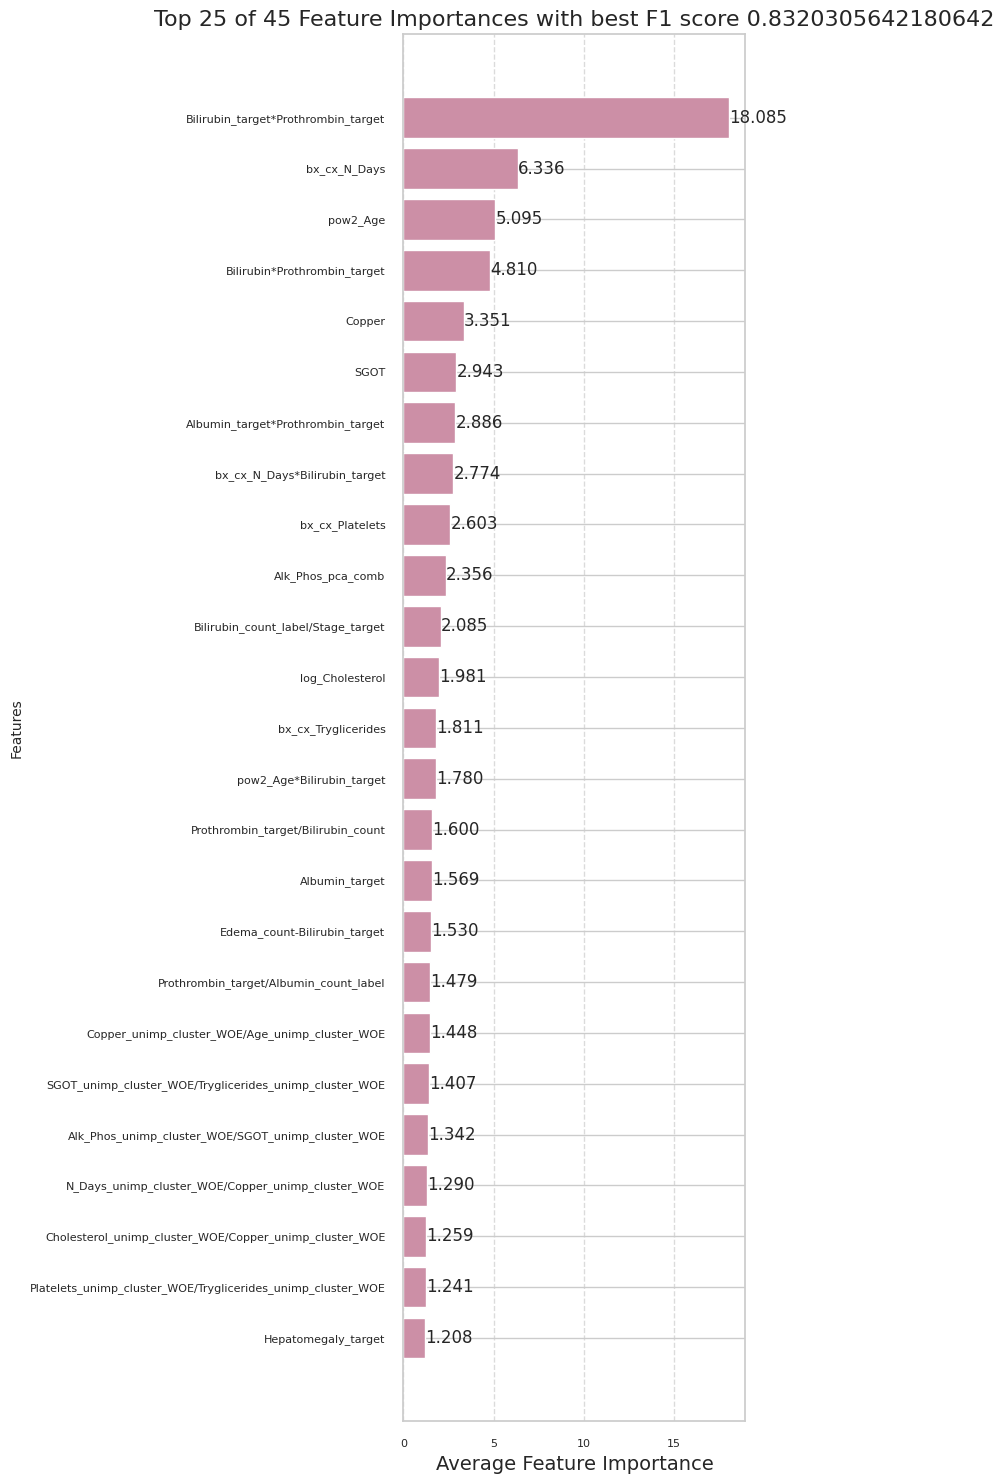

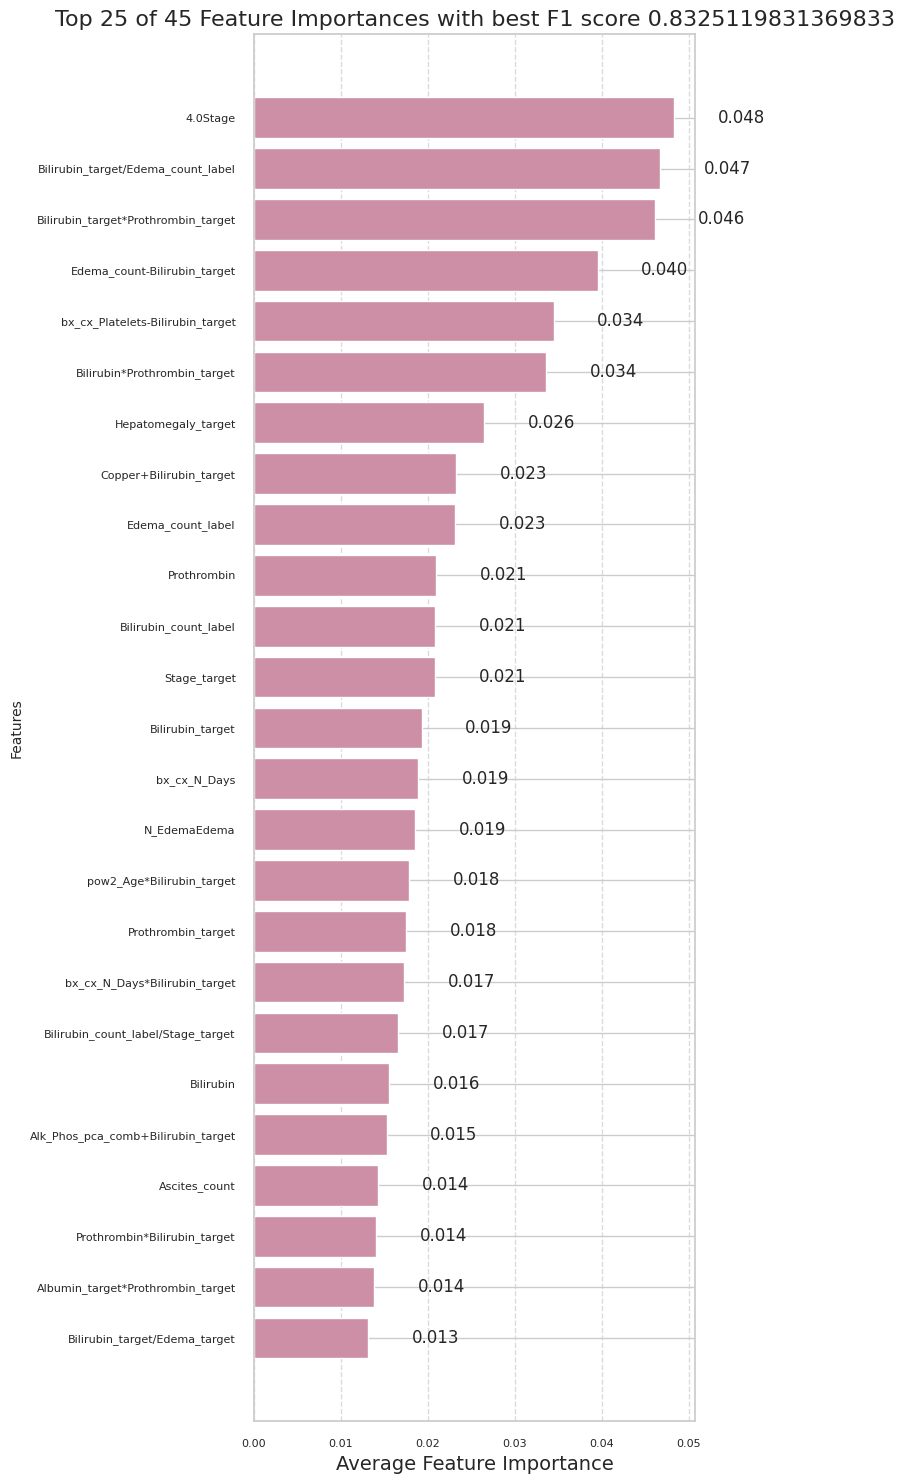

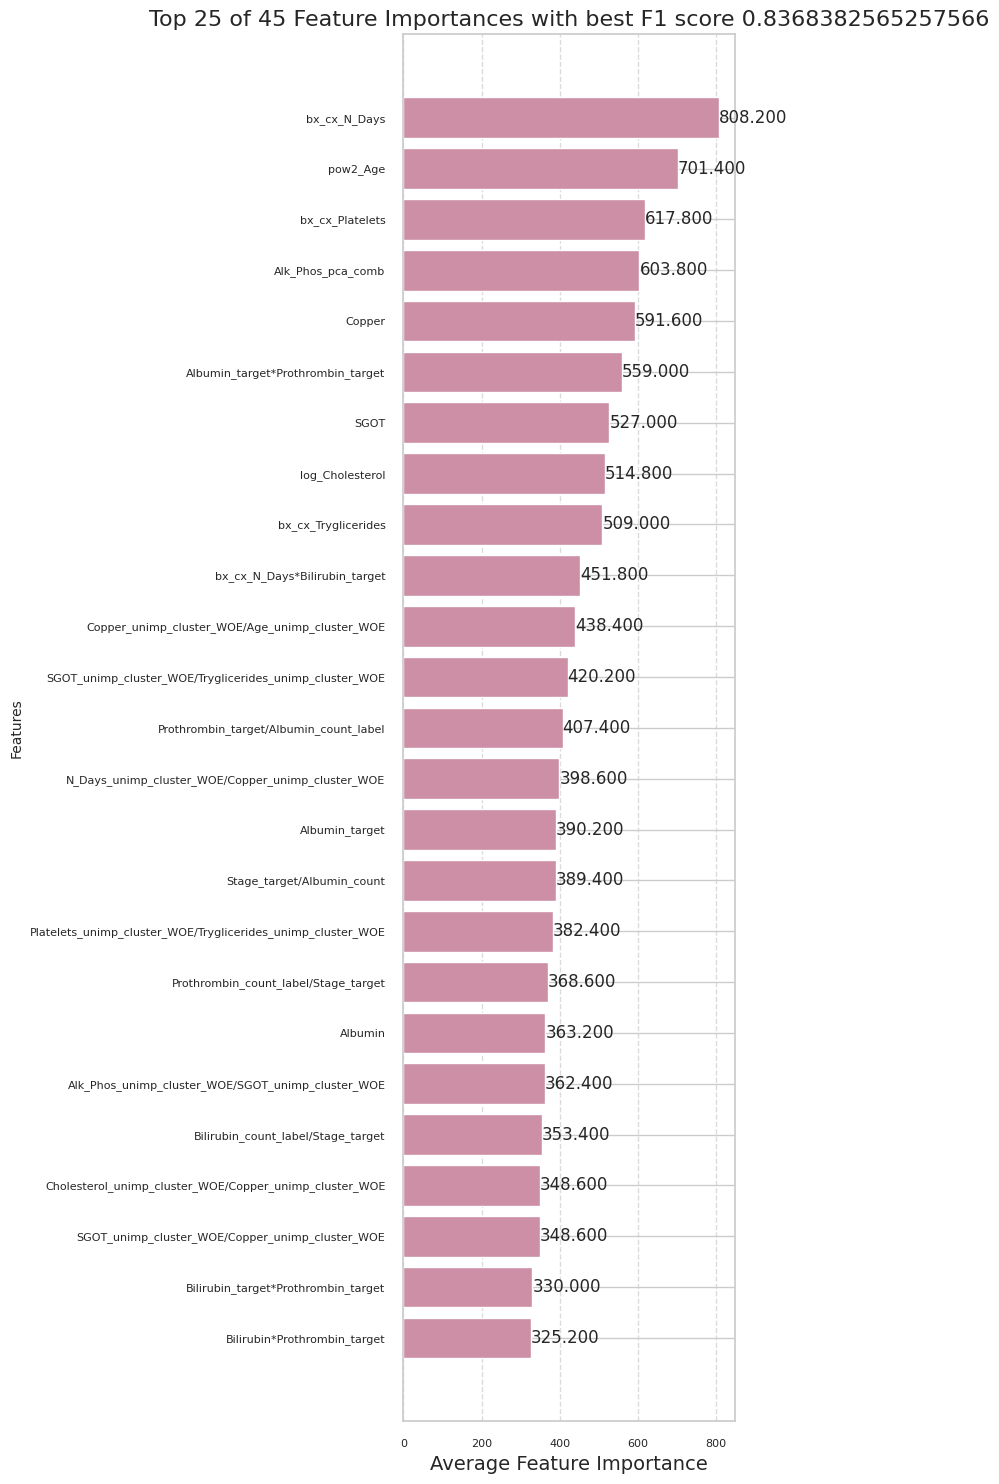

In [29]:
n_imp_features_cat=get_most_important_features(X_train.reset_index(drop=True), y_train,45, 'cat')
n_imp_features_xgb=get_most_important_features(X_train.reset_index(drop=True), y_train,45, 'xgb')
n_imp_features_lgbm=get_most_important_features(X_train.reset_index(drop=True), y_train,45, 'lgbm')

In [30]:
n_imp_features=[*set(n_imp_features_xgb+n_imp_features_lgbm+n_imp_features_cat)]
print(f"{len(n_imp_features)} features have been selected from three algorithms for the final model")

70 features have been selected from three algorithms for the final model


In [31]:
X_train=X_train[n_imp_features]
X_test=X_test[n_imp_features]

# 7. Modeling

# 7.1 Class Weights

In [32]:
classes = np.unique(y_train)  # Get unique class labels
class_to_index = {cls: idx for idx, cls in enumerate(classes)}
y_train_numeric = np.array([class_to_index[cls] for cls in y_train])

class_counts = np.bincount(y_train_numeric)

total_samples = len(y_train_numeric)

class_weights = total_samples / (len(classes) * class_counts)

class_weights_dict = {target_map[cls]: weight for cls, weight in zip(classes, class_weights)}

print("Class counts:", class_counts)
print("Total samples:", total_samples)
print("Class weights:", class_weights)
print("Class weights dictionary:", class_weights_dict)

Class counts: [5197  300 2826]
Total samples: 8323
Class weights: [0.53383362 9.24777778 0.98171739]
Class weights dictionary: {0: 0.533833621961388, 1: 9.247777777777777, 2: 0.9817173861759849}


## 7.2 Models

<font size="3"> The modeling section has been adapted and modified from the work of @[tetsutani](https://www.kaggle.com/code/tetsutani/ps3e13-eda-decomposition-ensemble-rankpredict/notebook) . Please upvote his work if you liked mine :)</font>

In [33]:
class Splitter:
    def __init__(self, test_size=0.2, kfold=True, n_splits=5):
        self.test_size = test_size
        self.kfold = kfold
        self.n_splits = n_splits

    def split_data(self, X, y, random_state_list):
        if self.kfold:
            for random_state in random_state_list:
                kf = KFold(n_splits=self.n_splits, random_state=random_state, shuffle=True)
                for train_index, val_index in kf.split(X, y):
                    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
                    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
                    yield X_train, X_val, y_train, y_val

class Classifier:
    def __init__(self, n_estimators=100, device="cpu", random_state=0):
        self.n_estimators = n_estimators
        self.device = device
        self.random_state = random_state
        self.models = self._define_model()
        self.len_models = len(self.models)
        
    def _define_model(self):
        
        xgb_params = {
            'n_estimators': self.n_estimators,
            'learning_rate': 0.05,
            'max_depth': 4,
            'subsample': 0.8,
            'colsample_bytree': 0.1,
            'n_jobs': -1,
            'eval_metric': 'merror',
            'objective': 'multi_logloss',
            'tree_method': 'hist',
            'verbosity': 0,
            'random_state': self.random_state,
            'class_weight':class_weights_dict,
        }
        if self.device == 'gpu':
            xgb_params['tree_method'] = 'gpu_hist'
            xgb_params['predictor'] = 'gpu_predictor'
            
        xgb_params2=xgb_params.copy() 
        xgb_params2['subsample']= 0.3
        xgb_params2['max_depth']=8
        xgb_params2['learning_rate']=0.005
        xgb_params2['colsample_bytree']=0.9

        xgb_params3=xgb_params.copy() 
        xgb_params3['subsample']= 0.6
        xgb_params3['max_depth']=6
        xgb_params3['learning_rate']=0.02
        xgb_params3['colsample_bytree']=0.7
        
        lgb_params = {
            'n_estimators': self.n_estimators,
            'max_depth': 8,
            'learning_rate': 0.02,
            'subsample': 0.20,
            'colsample_bytree': 0.56,
            'reg_alpha': 0.25,
            'reg_lambda': 5e-08,
            'objective': 'multi_logloss',
            'metric': 'multi_logloss',
            'boosting_type': 'gbdt',
            'device': self.device,
            'random_state': self.random_state,
            'class_weight':class_weights_dict,
        }
        lgb_params2 = {
            'n_estimators': self.n_estimators,
            'max_depth': 6,
            'learning_rate': 0.05,
            'subsample': 0.20,
            'colsample_bytree': 0.56,
            'reg_alpha': 0.25,
            'reg_lambda': 5e-08,
            'objective': 'multiclass',
            'metric': 'multi_logloss',
            'boosting_type': 'gbdt',
            'device': self.device,
            'random_state': self.random_state,
        }
        lgb_params3=lgb_params.copy()  
        lgb_params3['subsample']=0.9
        lgb_params3['reg_lambda']=0.3461495211744402
        lgb_params3['reg_alpha']=0.3095626288582237
        lgb_params3['max_depth']=10
        lgb_params3['learning_rate']=0.007
        lgb_params3['colsample_bytree']=0.5

        lgb_params4=lgb_params2.copy()  
        lgb_params4['subsample']=0.7
        lgb_params4['reg_lambda']=0.1
        lgb_params4['reg_alpha']=0.2
        lgb_params4['max_depth']=10
        lgb_params4['learning_rate']=0.007
        lgb_params4['colsample_bytree']=0.5
    
        cb_params = {
            'iterations': self.n_estimators,
            'depth': 6,
            'learning_rate': 0.05,
            'l2_leaf_reg': 0.7,
            'random_strength': 0.2,
            'max_bin': 200,
            'od_wait': 65,
            'one_hot_max_size': 70,
            'grow_policy': 'Depthwise',
            'bootstrap_type': 'Bayesian',
            'od_type': 'Iter',
            'eval_metric': 'MultiClass',
            'loss_function': 'MultiClass',
            'task_type': self.device.upper(),
            'random_state': self.random_state,
        }
        cb_sym_params = cb_params.copy()
        cb_sym_params['grow_policy'] = 'SymmetricTree'
        cb_loss_params = cb_params.copy()
        cb_loss_params['grow_policy'] = 'Lossguide'
        
        cb_params2=  cb_params.copy()
        cb_params2['learning_rate']=0.01
        cb_params2['depth']=8
        
        cb_params3={
            'iterations': self.n_estimators,
            'random_strength': 0.1, 
            'one_hot_max_size': 70, 'max_bin': 100, 
            'learning_rate': 0.008, 
            'l2_leaf_reg': 0.3, 
            'grow_policy': 'Depthwise', 
            'depth': 9, 
            'max_bin': 200,
            'od_wait': 65,
            'bootstrap_type': 'Bayesian',
            'od_type': 'Iter',
            'eval_metric': 'TotalF1',
            'loss_function': 'MultiClass',
            'task_type': self.device.upper(),
            'random_state': self.random_state,
        }
        cb_params4=  cb_params.copy()
        cb_params4['learning_rate']=0.01
        cb_params4['depth']=12
        dt_params= {'min_samples_split': 18, 'min_samples_leaf': 6, 'max_depth': 12, 'criterion': 'gini'}
        models = {
#             'svc': SVC(gamma="auto", probability=True, random_state=self.random_state),
            'xgb': xgb.XGBClassifier(**xgb_params),
            'xgb2': xgb.XGBClassifier(**xgb_params2),
            'xgb3': xgb.XGBClassifier(**xgb_params3),
            'xgb4': xgb.XGBClassifier(eval_metric= 'merror',objective= 'multi:softmax',tree_method= 'hist',verbosity= 0,random_state= self.random_state),
            'lgb': lgb.LGBMClassifier(**lgb_params),
            'lgb2': lgb.LGBMClassifier(**lgb_params2),
            'lgb3': lgb.LGBMClassifier(**lgb_params3),
            'lgb4': lgb.LGBMClassifier(**lgb_params4),
            'cat': CatBoostClassifier(**cb_params),
            'cat2': CatBoostClassifier(**cb_params2),
            'cat3': CatBoostClassifier(**cb_params2),
            'cat4': CatBoostClassifier(**cb_params2),
            "cat_sym": CatBoostClassifier(**cb_sym_params),
            "cat_loss": CatBoostClassifier(**cb_loss_params),
            'brf': BalancedRandomForestClassifier(n_estimators=4000, n_jobs=-1, random_state=self.random_state),
            'rf': RandomForestClassifier(n_estimators=1000, random_state=self.random_state),
            'hist_gbm' : HistGradientBoostingClassifier (max_iter=300, learning_rate=0.001,
                                                         max_depth=8,class_weight=class_weights_dict, random_state=self.random_state),
            'gbdt': GradientBoostingClassifier(max_depth=6,  n_estimators=1000,random_state=self.random_state),
            'etr': ExtraTreesClassifier(min_samples_split=55, min_samples_leaf= 15, max_depth=10,  n_estimators=200,random_state=self.random_state),
            'dt' : DecisionTreeClassifier(**dt_params,random_state=self.random_state),
            'ada': AdaBoostClassifier(random_state=self.random_state),
                                       
        }
        return models

## 7.3 Optimize Ensemble

In [34]:
class OptunaWeights:
    def __init__(self, random_state, n_trials=10000):
        self.study = None
        self.weights = None
        self.random_state = random_state
        self.n_trials = n_trials

    def _objective(self, trial, y_true, y_preds):
        # Define the weights for the predictions from each model
        weights = [trial.suggest_float(f"weight{n}", 0, 1) for n in range(len(y_preds))]

        # Calculate the weighted prediction
        weighted_pred = np.average(np.array(y_preds), axis=0, weights=weights)
        weighted_pred = weighted_pred/weighted_pred.sum(axis=1, keepdims=True)
        
        weighted_pred_labels = np.argmax(weighted_pred, axis=1)
        f1_micro_score = f1_score(y_true, weighted_pred_labels, average='micro')

        log_loss_score=log_loss(y_true, weighted_pred)
        return log_loss_score/f1_micro_score

    def fit(self, y_true, y_preds):
        optuna.logging.set_verbosity(optuna.logging.ERROR)
        sampler = optuna.samplers.CmaEsSampler(seed=self.random_state)
        pruner = optuna.pruners.HyperbandPruner()
        self.study = optuna.create_study(sampler=sampler, pruner=pruner, study_name="OptunaWeights", direction='minimize')
        objective_partial = partial(self._objective, y_true=y_true, y_preds=y_preds)
        self.study.optimize(objective_partial, n_trials=self.n_trials)
        self.weights = [self.study.best_params[f"weight{n}"] for n in range(len(y_preds))]

    def predict(self, y_preds):
        assert self.weights is not None, 'OptunaWeights error, must be fitted before predict'
        weighted_pred = np.average(np.array(y_preds), axis=0, weights=self.weights)
        return weighted_pred

    def fit_predict(self, y_true, y_preds):
        self.fit(y_true, y_preds)
        return self.predict(y_preds)
    
    def weights(self):
        return self.weights

## 7.4 Model Fit

In [35]:
kfold = True
n_splits = 1 if not kfold else 10
random_state = 42
random_state_list = [42] 
n_estimators = 9999 
early_stopping_rounds = 300
verbose = False
device = 'cpu'
splitter = Splitter(kfold=kfold, n_splits=n_splits)

# Initialize an array for storing test predictions
test_predss = np.zeros((X_test.shape[0], 3))
ensemble_score = []
ensemble_f1_score = []
weights = []
trained_models = {'xgb':[], 'lgb':[], 'cat':[]}
    
for i, (X_train_, X_val, y_train_, y_val) in enumerate(splitter.split_data(X_train, y_train, random_state_list=random_state_list)):
    n = i % n_splits
    m = i // n_splits
            
    # Get a set of Regressor models
    classifier = Classifier(n_estimators, device, random_state)
    models = classifier.models
    
    # Initialize lists to store oof and test predictions for each base model
    oof_preds = []
    test_preds = []
    
    # Loop over each base model and fit it to the training data, evaluate on validation data, and store predictions
    for name, model in models.items():
        if ('xgb' in name) or ('lgb' in name) or ('cat' in name)  :
            model.fit(X_train_, encode(y_train_,target_map), eval_set=[(X_val, encode(y_val,target_map))], early_stopping_rounds=early_stopping_rounds, verbose=verbose)
        else:
            model.fit(X_train_, encode(y_train_,target_map))
            
        if name in trained_models.keys():
            trained_models[f'{name}'].append(deepcopy(model))
        
        test_pred = model.predict_proba(X_test)
        y_val_pred = model.predict_proba(X_val)

        y_val_pred_labels = np.argmax(y_val_pred, axis=1)
        f1_micro_score = f1_score(encode(y_val,target_map), y_val_pred_labels, average='micro')
        
        score = log_loss(encode(y_val,target_map), y_val_pred)
        print(f'{name} [FOLD-{n} SEED-{random_state_list[m]}] F1 Micro Score: {f1_micro_score:.5f}, Logloss: {score:.5f}')
        
        oof_preds.append(y_val_pred)
        test_preds.append(test_pred)
    
    # Use Optuna to find the best ensemble weights
    optweights = OptunaWeights(random_state=random_state)
    y_val_pred = optweights.fit_predict(encode(y_val,target_map), oof_preds)
    
    score = log_loss(encode(y_val,target_map), y_val_pred)
    y_val_pred_labels = np.argmax(y_val_pred, axis=1)
    f1_micro_score = f1_score(encode(y_val,target_map), y_val_pred_labels, average='micro')
    
    print(f'Ensemble [FOLD-{n} SEED-{random_state_list[m]}] -------------------> F1 Micro Score: {f1_micro_score:.5f}, Logloss: {score:.5f}')
    
    ensemble_score.append(score)
    ensemble_f1_score.append(f1_micro_score)
    weights.append(optweights.weights)
    
    # Predict to X_test by the best ensemble weights
    _test_preds = optweights.predict(test_preds)
    test_predss += _test_preds / (n_splits * len(random_state_list))
    
    gc.collect()

xgb [FOLD-0 SEED-42] F1 Micro Score: 0.82473, Logloss: 0.44927
xgb2 [FOLD-0 SEED-42] F1 Micro Score: 0.82233, Logloss: 0.47871
xgb3 [FOLD-0 SEED-42] F1 Micro Score: 0.83193, Logloss: 0.44619
xgb4 [FOLD-0 SEED-42] F1 Micro Score: 0.82473, Logloss: 0.47135
lgb [FOLD-0 SEED-42] F1 Micro Score: 0.81993, Logloss: 0.45873
lgb2 [FOLD-0 SEED-42] F1 Micro Score: 0.82833, Logloss: 0.44419
lgb3 [FOLD-0 SEED-42] F1 Micro Score: 0.81633, Logloss: 0.45295
lgb4 [FOLD-0 SEED-42] F1 Micro Score: 0.82473, Logloss: 0.44601
cat [FOLD-0 SEED-42] F1 Micro Score: 0.82833, Logloss: 0.45028
cat2 [FOLD-0 SEED-42] F1 Micro Score: 0.82113, Logloss: 0.45427
cat3 [FOLD-0 SEED-42] F1 Micro Score: 0.82113, Logloss: 0.45427
cat4 [FOLD-0 SEED-42] F1 Micro Score: 0.82113, Logloss: 0.45427
cat_sym [FOLD-0 SEED-42] F1 Micro Score: 0.82593, Logloss: 0.44774
cat_loss [FOLD-0 SEED-42] F1 Micro Score: 0.82593, Logloss: 0.44652
brf [FOLD-0 SEED-42] F1 Micro Score: 0.72989, Logloss: 0.72401
rf [FOLD-0 SEED-42] F1 Micro Score: 0

In [36]:
# Calculate the mean LogLoss score of the ensemble
mean_score = np.mean(ensemble_score)
std_score = np.std(ensemble_score)
print(f'Ensemble Log Loss score {mean_score:.5f} ± {std_score:.5f}')

# Print the mean and standard deviation of the ensemble weights for each model
print('--- Model Weights ---')
mean_weights = np.mean(weights, axis=0)
std_weights = np.std(weights, axis=0)
for name, mean_weight, std_weight in zip(models.keys(), mean_weights, std_weights):
    print(f'{name}: {mean_weight:.5f} ± {std_weight:.5f}')

Ensemble Log Loss score 0.42172 ± 0.01908
--- Model Weights ---
xgb: 0.87948 ± 0.14860
xgb2: 0.00206 ± 0.00245
xgb3: 0.36614 ± 0.33357
xgb4: 0.21902 ± 0.32707
lgb: 0.24390 ± 0.22665
lgb2: 0.34947 ± 0.37716
lgb3: 0.70973 ± 0.36008
lgb4: 0.51788 ± 0.41901
cat: 0.30765 ± 0.36168
cat2: 0.04973 ± 0.07125
cat3: 0.01754 ± 0.03960
cat4: 0.07202 ± 0.13840
cat_sym: 0.37828 ± 0.39875
cat_loss: 0.35096 ± 0.37838
brf: 0.01333 ± 0.02408
rf: 0.07166 ± 0.11109
hist_gbm: 0.00915 ± 0.02426
gbdt: 0.26235 ± 0.21398
etr: 0.18123 ± 0.22551
dt: 0.10352 ± 0.13198
ada: 0.01139 ± 0.01816


## 7.5 Feature Importance Visualization

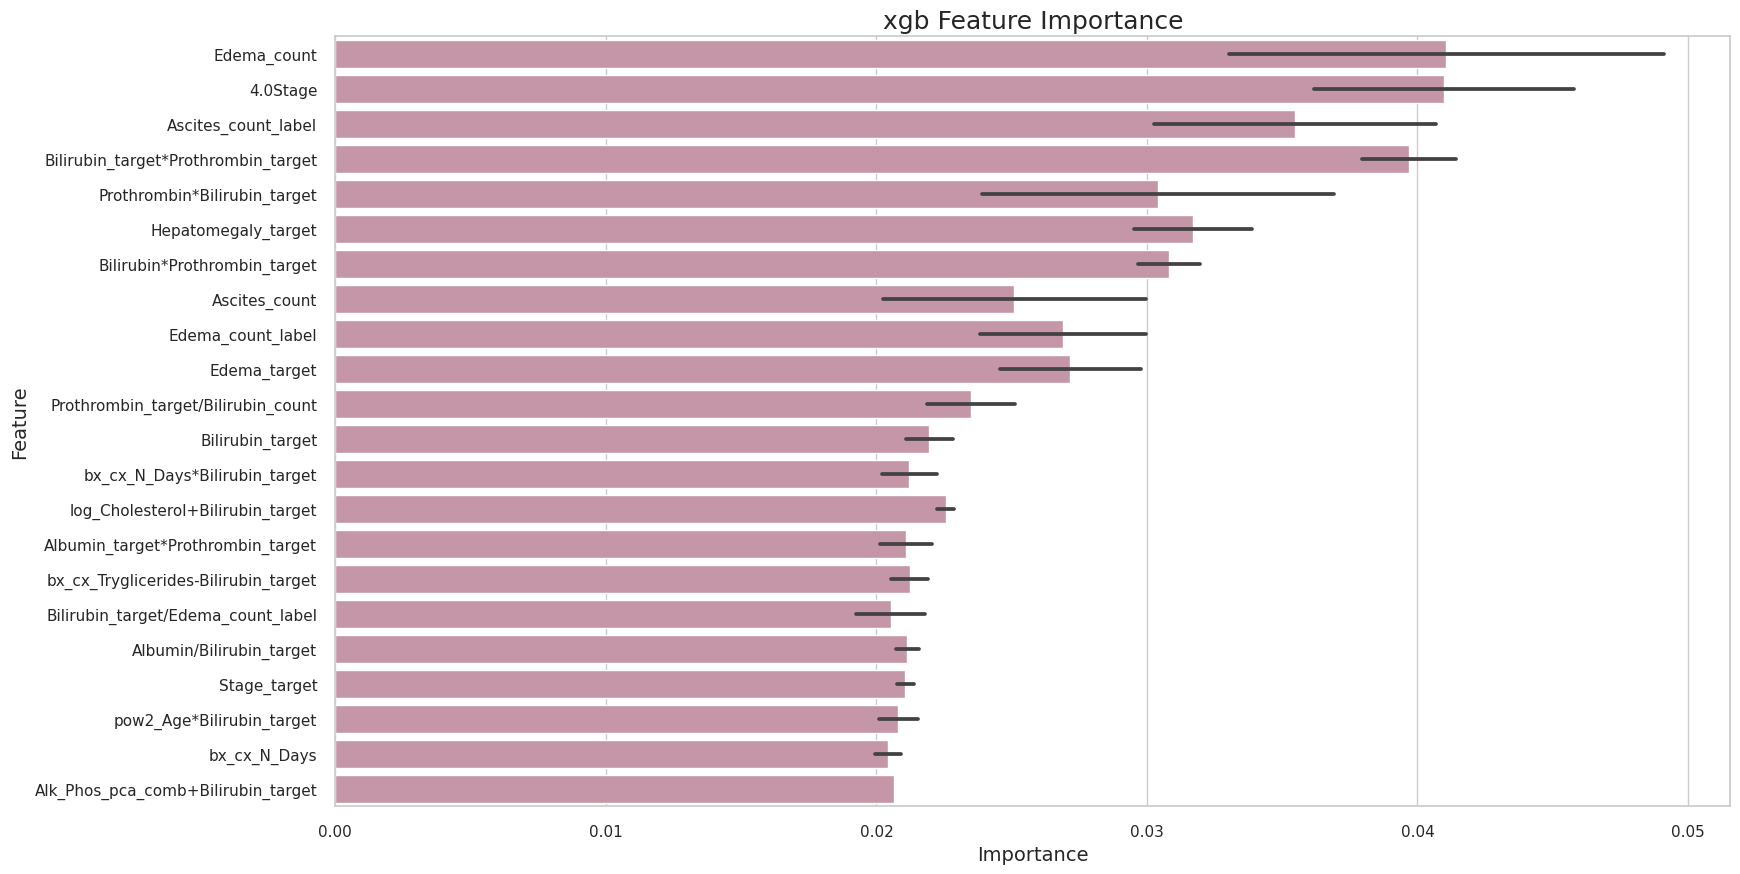

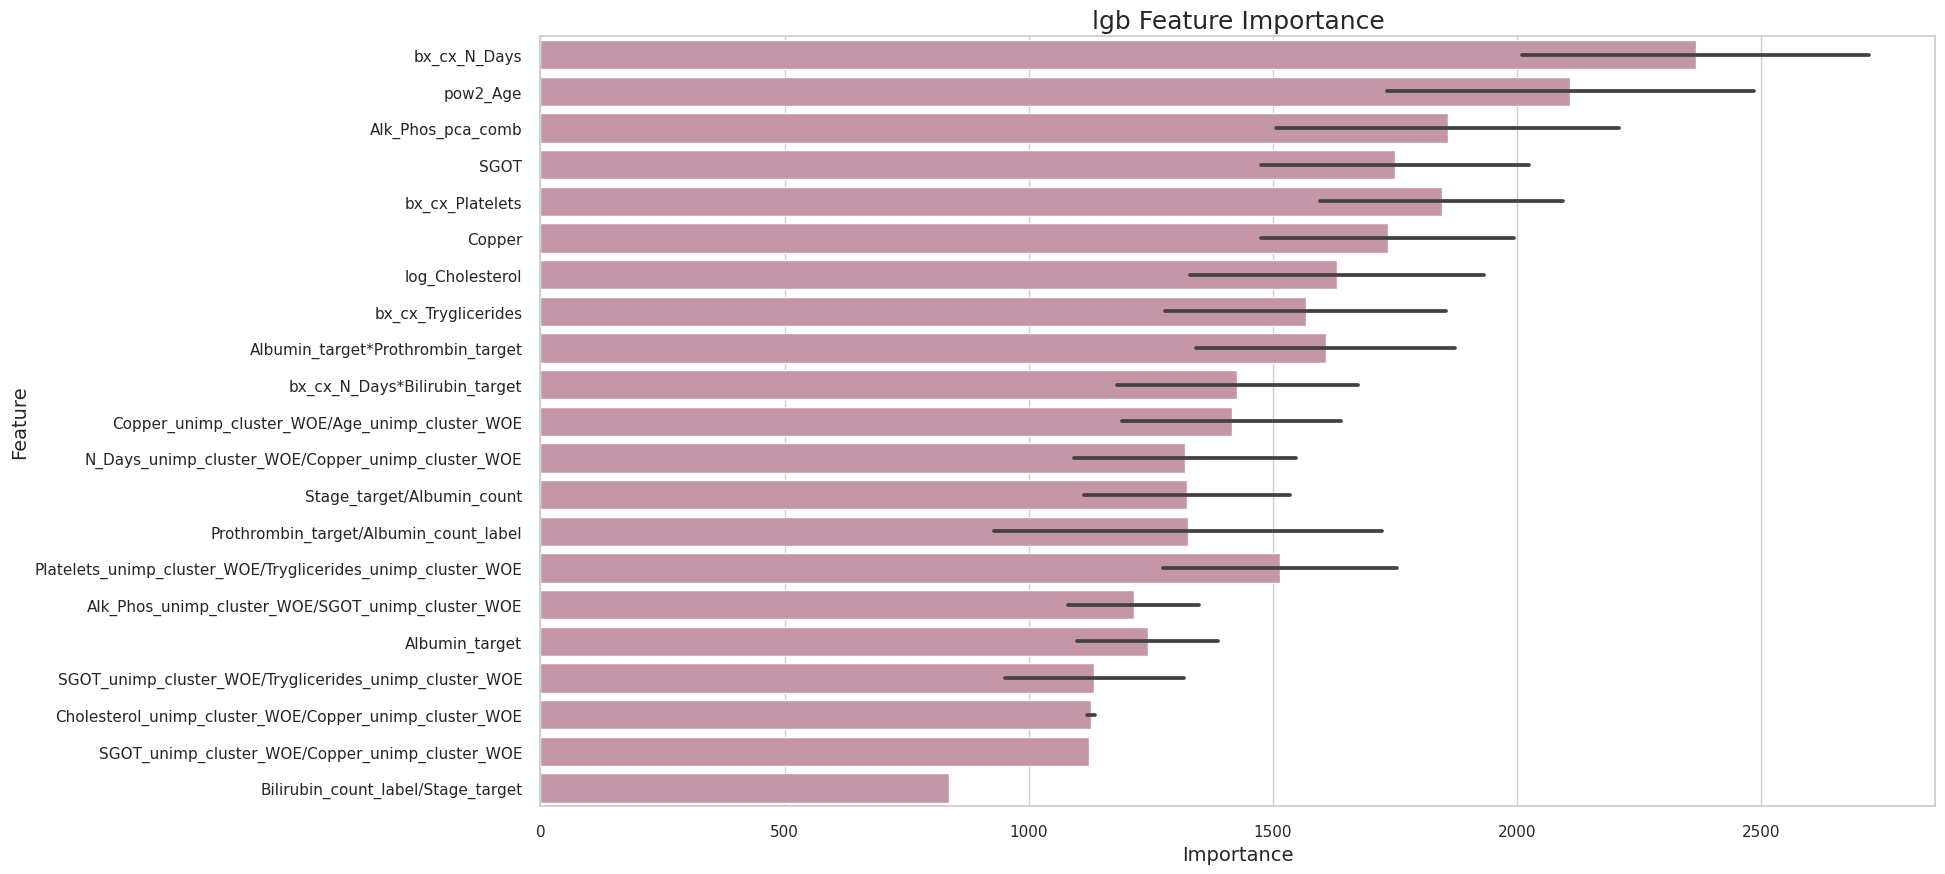

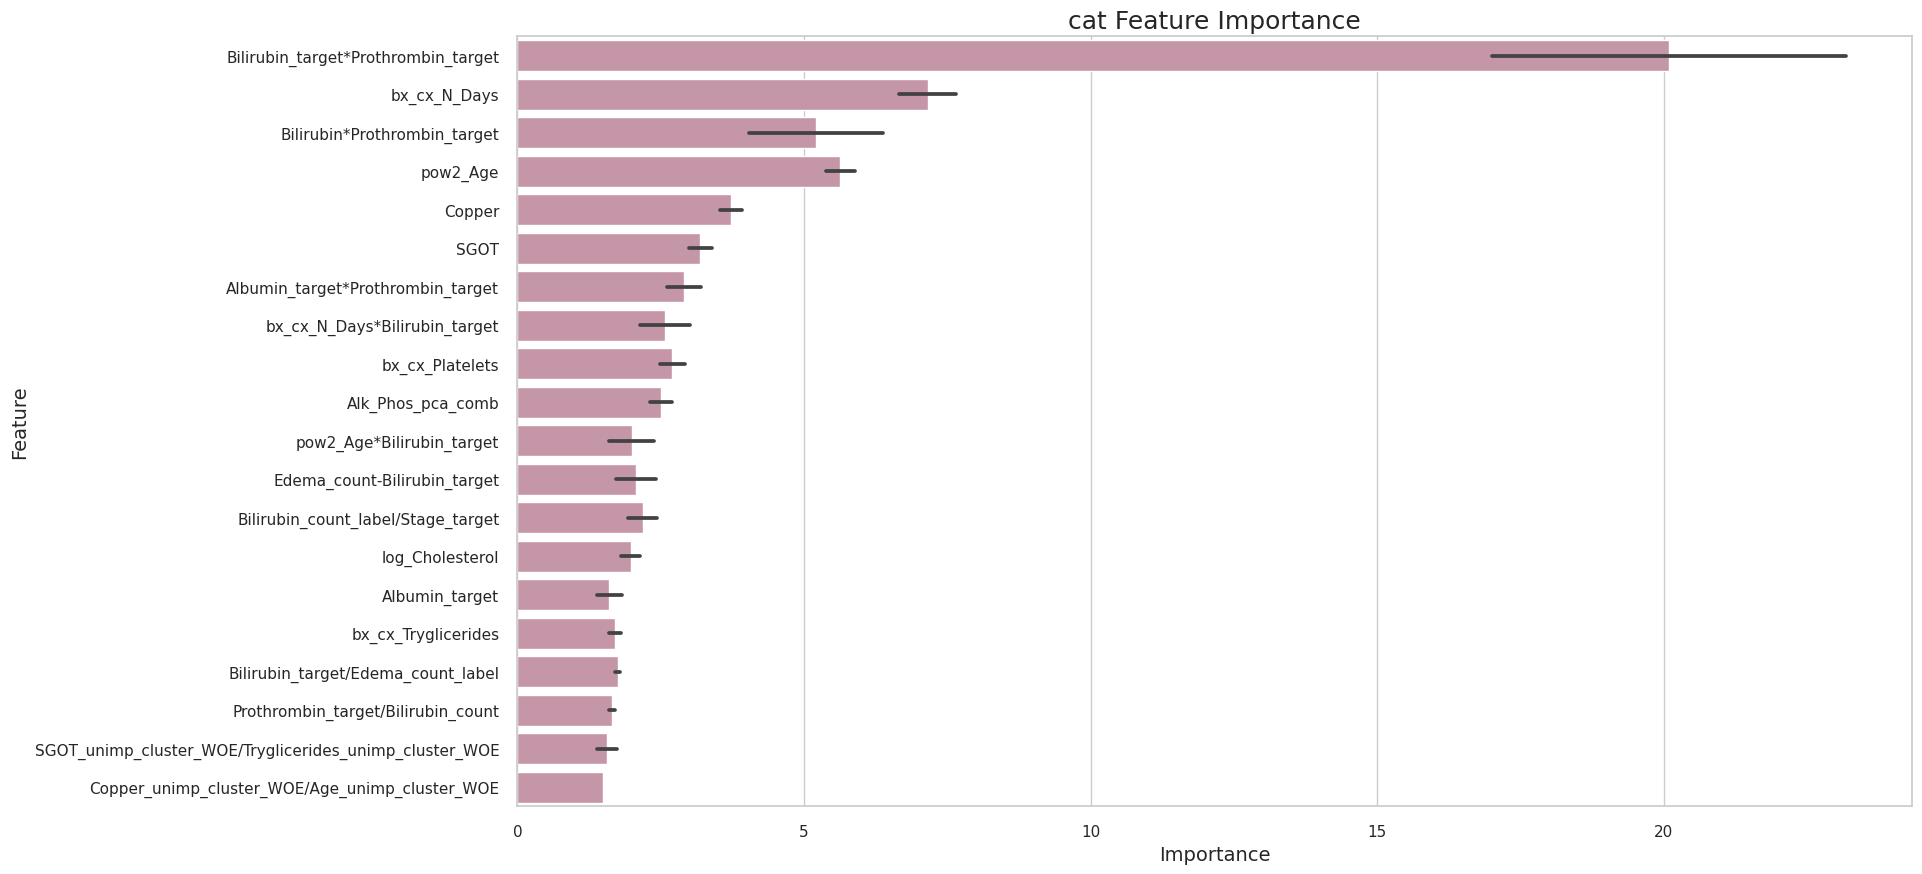

In [37]:
def visualize_importance(models, feature_cols, title, head=15):
    importances = []
    feature_importance = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df["importance"] = model.feature_importances_
        _df["feature"] = pd.Series(feature_cols)
        _df["fold"] = i
        _df = _df.sort_values('importance', ascending=False)
        _df = _df.head(head)
        feature_importance = pd.concat([feature_importance, _df], axis=0, ignore_index=True)
        
    feature_importance = feature_importance.sort_values('importance', ascending=False)
    # display(feature_importance.groupby(["feature"]).mean().reset_index().drop('fold', axis=1))
    plt.figure(figsize=(18, 10))
    sns.barplot(x='importance', y='feature', data=feature_importance, color= (0.8, 0.56, 0.65), errorbar='sd')
    plt.xlabel('Importance', fontsize=14)
    plt.ylabel('Feature', fontsize=14)
    plt.title(f'{title} Feature Importance', fontsize=18)
    plt.grid(True, axis='x')
    plt.show()
    
for name, models in trained_models.items():
    visualize_importance(models, list(X_train.columns), name)

## 7.6 Submission

In [38]:
sub = pd.read_csv('/kaggle/input/playground-series-s3e26/sample_submission.csv')

cols=['Status_C','Status_CL','Status_D']

sub[cols] =  test_predss
sub[cols]=sub[cols].div(sub[cols].sum(axis=1), axis=0)
sub.to_csv('submission_pure.csv',index=False)
sub.head()

,id,Status_C,Status_CL,Status_D
0,7905,0.626104,0.035678,0.338218
1,7906,0.534777,0.172798,0.292425
2,7907,0.019709,0.012492,0.967799
3,7908,0.968680,0.007963,0.023357
4,7909,0.883768,0.045222,0.071010


## 7.7 Generalization Ensemble

In [39]:
sub1=pd.read_csv('/kaggle/input/s03e26-blend/submission.csv')
sub2=pd.read_csv('/kaggle/input/ps-s3-e26-lgbm-xgb-preprocessing-fasteda/submission.csv')
sub3=pd.read_csv('/kaggle/input/k/kamilla1158/s03e26-blend/submission.csv')
sub4=pd.read_csv("/kaggle/input/ps-s3-e26-lgbm-xgb-preprocessing-fasteda/submission.csv")
sub5=pd.read_csv("/kaggle/input/multi-class-prediction-of-cirrhosis-outcomes/submission.csv")
sub6=pd.read_csv("/kaggle/input/ps3e25-cirrhosis-multi-class-solution/submission.csv")
sub7=pd.read_csv("/kaggle/input/s3e26-xgbclassifer-lgbmclassifier/submission.csv")


sub_list=[sub1,sub2,sub,sub3,sub4,sub5,sub6,sub7]
def ensemble_mean(sub_list):
    
    sub_out=sub_list[0].copy()
    
    for col in cols:
        sub_out[col]=sum(df[col] for df in sub_list)/len(sub_list)
    sub_out[cols]=sub_out[cols].div(sub_out[cols].sum(axis=1), axis=0)
    
    return sub_out
    
sub_ensemble=ensemble_mean(sub_list)
sub_ensemble.to_csv('submission.csv',index=False)
sub_ensemble.head()

,id,Status_C,Status_CL,Status_D
0,7905,0.474476,0.034168,0.491356
1,7906,0.474838,0.250797,0.274365
2,7907,0.033102,0.012846,0.954052
3,7908,0.972169,0.004607,0.023225
4,7909,0.840625,0.057925,0.101450
